# Описание проекта

__Описание проекта__


HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


__Цель исследования__

Определить ключевые факторы, влияющие на удовлетворённость сотрудников и вероятность их увольнения.

Построить и сравнить модели машинного обучения для прогнозирования уровня удовлетворённости и увольнения, выбрав оптимальные по метрикам SMAPE (для регрессии) и ROC-AUC (для классификации).

На основе полученных результатов выявить группы риска и разработать практические рекомендации для HR-департамента по повышению вовлечённости и снижению текучести кадров.


__Ход исследования__

1. [Задача 1: предсказание уровня удовлетворённости сотрудника](#задача_1) 

    1.1 [Загрузка данных](#загрузка_данных)  
    1.2 [Предобработка данных](#предобработка_данных)  
    1.3 [Исследовательский анализ данных](#исследовательский_анализ_данных)  
    1.4 [Корреляционный анализ](#корреляционный_анализ)  
    1.5 [Использование пайплайнов](#использование_пайплайнов)  
    1.6 [Заключение и выводы](#заключение_выводы)


2. [Задача 2: предсказание увольнения сотрудника из компании](#задача_2)

    2.1 [Загрузка данных](#загрузка_данных_2)  
    2.2 [Предобработка данных](#предобработка_данных_2)  
    2.3 [Исследовательский анализ данных](#исследовательский_анализ_данных_2)  
    2.4 [Корреляционный анализ](#корреляционный_анализ_2)  
    2.5 [Портрет «уволившегося сотрудника](#сотрудник)    
    2.6 [Проверка утверждения: «Уровень удовлетворённости сотрудника работой (job_satisfaction_rate) влияет на то, уволится ли сотрудник.»](#проверка)  
    2.7 [Добавление нового входного признака](#добавление)   
    2.8 [Подготовка данных](#подготовка)   
    2.9 [Обучение модели (Задача 2: предсказать quit)](#обучение)


3. [Общий вывод по проекту](#выводы)

## Задача 1: предсказание уровня удовлетворённости сотрудника <a id="задача_1"></a>

### Загрузка данных <a id="загрузка_данных"></a>

In [1]:
# Для установки модуля 'phik' 
!pip install -q phik

In [2]:
# Обновление scikit-learn
!pip install -q -U scikit-learn

In [3]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings, re
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind

In [4]:
# Настройки окружения и константы проекта
warnings.filterwarnings(
    "ignore",
    message=".*keepdims.*",
    category=FutureWarning
)

RANDOM_STATE = 42

In [5]:
# Загружаем датасеты
train = pd.read_csv('../data/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('../data/test_features.csv')
test_target = pd.read_csv('../data/test_target_job_satisfaction_rate.csv')

### Предобработка данных <a id="предобработка_данных"></a>

__Создадим функцию для вывода нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)__

In [6]:
def look_data(x):
    print('------------- Исходный датафрейм (5 cтрок) -------------')
    display(x.head())
    print('')
    print('')
    print('------------- Общая информация о датафрейме -------------')
    print('')
    print('')
    display(x.info())
    print('------------- Количество пустых значений в датафрейме -------------')
    print('')
    print('')
    display(x.isna().sum())
    print('------------- Количество явных дубликатов в датафрейме -------------')
    display(x.duplicated().sum())
    print('')
    print('')
    print('------------- Описательная статистика -------------')
    display(x.drop(columns=['id']).describe())
    print('------------- Проверим уникальные значения нечисловых колонок -------------')
    print('')
    print('')
    object_cols = x.select_dtypes(include='object').columns
    for col in object_cols:
        unique_vals = x[col].unique()
        print(f"Столбец: {col}")
        print(f"Количество уникальных значений: {len(unique_vals)}")
        print(f"Уникальные значения: {unique_vals}")
        print('-' * 60)

#### Вывод нужных характеристик - Тренировочная выборка

In [7]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
look_data(train)

------------- Исходный датафрейм (5 cтрок) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

------------- Количество пустых значений в датафрейме -------------




id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: dept
Количество уникальных значений: 6
Уникальные значения: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
------------------------------------------------------------
Столбец: level
Количество уникальных значений: 4
Уникальные значения: ['junior' 'middle' 'sinior' nan]
------------------------------------------------------------
Столбец: workload
Количество уникальных значений: 3
Уникальные значения: ['medium' 'high' 'low']
------------------------------------------------------------
Столбец: last_year_promo
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------
Столбец: last_year_violations
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------


##### Краткий вывод по данным "Тренировочная выборка"

1. Размер, типы, целевая

* 4000 строк × 10 столбцов.
* Типы: 5 object, 4 int, 1 float.
* Целевая переменная job_satisfaction_rate находится в этом же датафрейме, без пропусков.

2. Пропуски и дубликаты

* Пропуски: dept — 6 (≈0,15%), level — 4 (≈0,10%); остальные — 0.
* Явных дубликатов строк — 0.

3. Категориальные признаки (уникальные значения)

* dept: 6 категорий — ['sales', 'hr', 'technology', 'purchasing', 'marketing', NaN].
* level: 3 валидные категории — ['junior', 'middle', 'sinior', NaN] — есть опечатка **'sinior'** (нужно исправить на 'senior').
* workload: 3 категории — ['medium', 'high', 'low'].
* last_year_promo / last_year_violations: бинарные — ['no', 'yes'].

4. Числовые признаки — основные статистики

* employment_years: min=1, Q1=2, median=3, mean=3.72, Q3=6, max=10.
* supervisor_evaluation: 1–5, median=4, mean≈3.48.
* salary: min=12 000, Q1=22 800, median=30 000, Q3=43 200, max=98 400, mean≈33 927.
* job_satisfaction_rate: диапазон 0.03–1.00, median=0.56, mean≈0.534, std≈0.225 (сконцентрирована вокруг средних значений).

5. Что это значит для предобработки

* Исправить опечатку в level: 'sinior' → 'senior'.
* Заполнить NaN, пустные значения в dept и level (most_frequent/отдельная категория).
* Закодировать категориальные (One-Hot/Ordinal по выбранной модели).
* Масштабировать числовые, как минимум salary (существенно отличается по масштабу).
* Дополнительно: проверить выбросы по salary и согласованность категорий между train/test после очистки.


##### Устраняем опечатку в level: 'sinior' → 'senior'

In [8]:
train.loc[:, 'level'] = train['level'].replace('sinior', 'senior')

__Проверка__

In [9]:
train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

__Все опечатки 'sinior' исправлены на 'senior'__

#### Вывод нужных характеристик - Входные признаки тестовой выборки

In [10]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
look_data(test_features)

------------- Исходный датафрейм (5 cтрок) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

------------- Количество пустых значений в датафрейме -------------




id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: dept
Количество уникальных значений: 7
Уникальные значения: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
------------------------------------------------------------
Столбец: level
Количество уникальных значений: 4
Уникальные значения: ['junior' 'middle' 'sinior' nan]
------------------------------------------------------------
Столбец: workload
Количество уникальных значений: 4
Уникальные значения: ['medium' 'low' 'high' ' ']
------------------------------------------------------------
Столбец: last_year_promo
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------
Столбец: last_year_violations
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------


##### Краткий вывод по данным "Входные признаки тестовой выборки"

1. Размер и типы

* 2000 строк × 9 столбцов.
* Типы: 5 object, 4 int.
* Целевой признак отсутствует в этом файле (это только признаки).

2. Пропуски и дубликаты

* Пропуски: dept — 2 (0,1%), level — 1 (0,05%); остальные — 0.
* Явных дубликатов строк — 0.

3. Категориальные признаки (уникальные значения)

* dept: 7 категорий — ['marketing', 'hr', 'sales', 'purchasing', 'technology', NaN, **' '**] → присутствует пустое значение **' '** как «мусорная» категория.
* level: 4 уровня — ['junior', 'middle', **'sinior'**, NaN] → опечатка **'sinior'** (нужно заменить на 'senior').
* workload: 4 значения — ['medium', 'low', 'high', **' '**] → лишнее пустое **' '** (надо нормализовать).
* last_year_promo / last_year_violations: бинарные — ['no', 'yes'].

4. Числовые признаки — основные статистики

* employment_years: min=1, Q1=1, median=3, mean=3.667, Q3=6, max=10.
* supervisor_evaluation: 1–5, median=4, mean≈3.527.
* salary: min=12 000, Q1=22 800, median=30 000, Q3=43 200, max=96 000, mean≈34 067.
* id: в диапазоне 100 298–999 029 (служебный идентификатор).

5. Что это значит для предобработки

* Привести пустые строки **' '** в dept и workload к NaN (затем обработать пропуски) или к отдельной категории 
* Исправить опечатку в level: **'sinior' → 'senior'** (и синхронизировать с train).
* Заполнить NaN, пустные значения в dept и level (most_frequent/отдельная категория).
* Кодировать категориальные (One-Hot/Ordinal), масштабировать числовые по необходимости (особенно **salary**).
* Проверить после чистки согласованность категорий train/test.


__Также присутствует пустая строка - пробел **' '**__

In [11]:
test_features[test_features['dept']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


__ID 822186__

In [12]:
for_822186 = test_features[
    (test_features['level'] == 'middle') &
    (test_features['workload'] == 'medium') &
    (test_features['employment_years'] == 3) &
    (test_features['salary'] == 38400) &
    (test_features['last_year_promo'] == 'no') &
    (test_features['last_year_violations'] == 'no') &
    (test_features['supervisor_evaluation'] == 4)
]
for_822186

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1048,995943,sales,middle,medium,3,no,no,4,38400
1699,822186,,middle,medium,3,no,no,4,38400
1724,273718,sales,middle,medium,3,no,no,4,38400


- Сравнение с сотрудниками со схожими параметрами показывает, что большинство работают в отделе sales.

- Присвоен отдел: sales

Заполняем пропуск

In [13]:
test_features.loc[test_features['id'] == 822186, 'dept'] = for_822186['dept'].mode()[0]

Проверка

In [14]:
test_features[test_features['id'] == 822186]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,sales,middle,medium,3,no,no,4,38400


##### Обработка пропусков в столбце 'workload' — Входные признаки тестовой выборки

In [15]:
test_features[test_features['workload'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [16]:
test_features[test_features['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


__Есть пустое (некорректное) значение в столбце 'workload'__

__В выборке столбец workload содержится 1 пустое значение .__

Для их восстановления проведён анализ строк и подбор аналогичных записей по остальным признакам: dept, level, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary.

Такой подход позволяет логически определить, к какому workload с наибольшей вероятностью относится сотрудник с пропуском, исходя из типичных характеристик работников.

__Поиск аналогов и выводы по каждому случаю__

__1) ID 590867__

In [17]:
for_590867= test_features[
    (test_features['dept'] == 'marketing') &
    (test_features['level'] == 'junior') &
    (test_features['employment_years'] == 4) &
    (test_features['salary'] >= 26000) &
    (test_features['salary'] <= 32800) &
    (test_features['last_year_promo'] == 'no') &
    (test_features['last_year_violations'] == 'no') &
    (test_features['supervisor_evaluation'] == 4)
]
for_590867

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
539,264208,marketing,junior,medium,4,no,no,4,27600
1392,667957,marketing,junior,medium,4,no,no,4,31200


- Сравнение с сотрудниками со схожими параметрами показывает, что большинство работают в отделе sales.

- Присвоен отдел: sales

Заполняем пропуск

In [18]:
test_features.loc[test_features['id'] == 590867, 'workload'] = for_590867['workload'].mode()[0]

Проверка

In [19]:
test_features[test_features['id'] == 590867]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,medium,4,no,no,4,28800


__Проверка столбца workload на пустые значения__

In [20]:
test_features[test_features['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


- Cтолбец workload не содержит пропусков, пустых значений
- Пустые значения в workload успешно заполнены с использованием логического анализа и сопоставления по близким признакам.

##### Устраняем опечатку в level: 'sinior' → 'senior'

In [21]:
test_features.loc[:, 'level'] = test_features['level'].replace('sinior', 'senior')

__Проверка__

In [22]:
train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

#### Вывод нужных характеристик - Целевой признак тестовой выборки

In [23]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
look_data(test_target)

------------- Исходный датафрейм (5 cтрок) -------------


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

------------- Количество пустых значений в датафрейме -------------




id                       0
job_satisfaction_rate    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


------------- Проверим уникальные значения нечисловых колонок -------------




__Краткий вывод по данным "Целевой признак тестовой выборки"__

1. Размер и типы

* 2000 строк × 2 столбца.
* Типы: id — int, job_satisfaction_rate — float.

2. Пропуски и дубликаты

* Пропуски: id — 0, job_satisfaction_rate — 0.
* Явных дубликатов строк — 0.

3. Целевой признак (job_satisfaction_rate) — основные статистики

* Диапазон: 0.03–1.00.
* Центр: median=0.58, mean≈0.549, std≈0.220.
* Квартильный размах: Q1=0.38, Q3=0.72 (сместен к средним/высоким значениям).

4. Идентификатор id

* Служебный ключ для джойна с test_features; распределён от 100 298 до 999 029.

5. Что это значит для предобработки/валидации

* Проверить, что все id из test_target сопоставимы с id из test_features (полнота и отсутствие «осиротевших» строк).
* Не использовать id как признак в модели.
* Масштабирование целевой не требуется (уже [0,1])


#### Итог выполненных действий

__Выполнена предобработка признаков:__

- В процессе проверки выявлены незначительные пропуски:

        в тренировочной выборке:

        dept — 6 пропусков

        level — 4 пропуска

        в тестовой выборке:

        dept — 2 пропуска, 1 пустое(некорректное) значение

        level — 1 пропуск.

        workload - 1 пустое (некорретное) значение

        Пропуски будут заполняются через SimpleImputer (в составе Pipeline), то есть обрабатываться автоматически во время обучения модели.
        Пустые (некорретные) значение имели логическую природу, поэтому были обработаны контекстным восстановлением.

- исправлены опечатки в значениях категорий;
        В столбце level выявлена опечатка 'sinior', заменённая на 'senior'.
        После исправления уникальные значения составили:
        ['junior', 'middle', 'senior'].

- подготовлены данные для последующего кодирования и масштабирования.


Три набора данных:

* **Тренировочная выборка:** 4000 записей, 10 признаков.
* **Тестовая выборка:** 2000 записей, 9 признаков.
* **Целевая тестовая выборка:** 2000 записей, 2 признака (id и `job_satisfaction_rate`).

Все выборки полностью согласованы по структуре и составу признаков.

### Исследовательский анализ данных <a id="исследовательский_анализ_данных"></a>

__Создадим вспомогательную функции для EDA__

__Разделение признаков на continuous / discrete / category:__

In [24]:
# категориальные признаки
category = [
    'dept',                  
    'level',                 
    'workload',             
    'last_year_promo',       
    'last_year_violations',
    'quit'
]

# дискретные числовые признаки
discrete = [
    'employment_years',      
    'supervisor_evaluation' 
]

# непрерывные числовые признаки
continuous = [
    'salary',                
    'job_satisfaction_rate',
    'job_satisfaction_pred'
]


__Словарь подписей (для нашей функции): ключ = имя столбца, значение = [title, xlabel, ylabel]:__

In [25]:
label_dict = {
    # категориальные
    'dept': ["Распределение по отделам", "Отдел", "Количество сотрудников"],
    'level': ["Распределение по уровням должностей", "Уровень должности", "Количество сотрудников"],
    'workload': ["Рабочая нагрузка сотрудников", "Уровень загруженности", "Количество сотрудников"],
    'last_year_promo': ["Повышения за последний год", "Наличие повышения (да/нет)", "Количество сотрудников"],
    'last_year_violations': ["Нарушения трудового договора", "Наличие нарушений (да/нет)", "Количество сотрудников"],
    'quit': ["Распределение по увольнениям", "Факт увольнения (yes/no)", "Количество сотрудников"],
    
    # дискретные числовые
    'employment_years': ["Стаж работы сотрудников", "Количество лет", "Количество сотрудников"],
    'supervisor_evaluation': ["Оценки руководителя", "Баллы (1–5)", "Количество сотрудников"],

    # непрерывные числовые
    'salary': ["Распределение заработной платы", "Зарплата (у.е.)", "Количество сотрудников"],
    'job_satisfaction_rate': ["Распределение уровня удовлетворённости", "Уровень удовлетворённости (0–1)", "Количество сотрудников"]
}


__Функция для EDA__

In [26]:
def learn_data(df):
    def get_labels(col):
        vals = label_dict.get(col, None)
        if vals is None:
            return [f"Распределение: {col}", col, "Количество наблюдений"]
        vals = list(vals) + [""] * (3 - len(vals))
        return vals[:3]

    for col in df.columns:
        if col == 'id':
            continue

        print(f"\n==== {col} ==== \n")
        title, xlabel, ylabel = get_labels(col)

        # Непрерывные
        if col in continuous:
            print(df[col].describe(), "\n")

            # Гистограмма
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=30)
            plt.title(title if title else f"Гистограмма: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.tight_layout()
            plt.show()

            # Boxplot
            plt.figure(figsize=(4, 6))
            plt.boxplot(df[col].dropna(), vert=True, showmeans=True)
            plt.title(f"Boxplot: {col}")
            plt.ylabel(xlabel if xlabel else col)
            plt.tight_layout()
            plt.show()

        # Дискретные
        elif col in discrete:
            print(df[col].describe(), "\n")
            
            # bar chart
            plt.figure(figsize=(6, 4))
            df[col].value_counts(dropna=False).sort_index().plot(
                kind="bar", grid=True
            )
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        # Категориальные
        elif col in category:
            print(df[col].describe(), "\n")
            
            # bar chart
            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
            
            # pie chart           
            plt.figure(figsize=(5, 5))
            plt.pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                counterclock=False,
                wedgeprops={'edgecolor': 'white'}
            )
            pie_title = f"Доля категорий — {xlabel}" if xlabel else f"Доля категорий: {col}"
            plt.title(pie_title)
            plt.tight_layout()
            plt.show()

        else:
            # Фоллбэк для непомеченных колонок
            print(df[col].describe(), "\n")
            counts = df[col].value_counts(dropna=False)
            
            # bar chart
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()


==== dept ==== 

count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object 



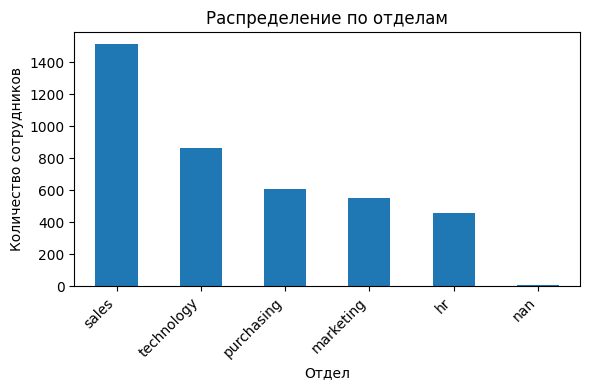

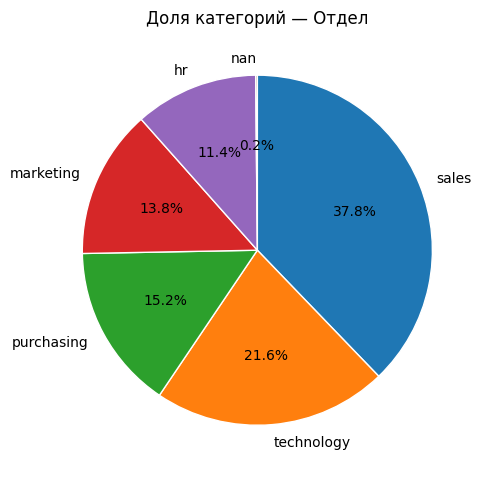


==== level ==== 

count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object 



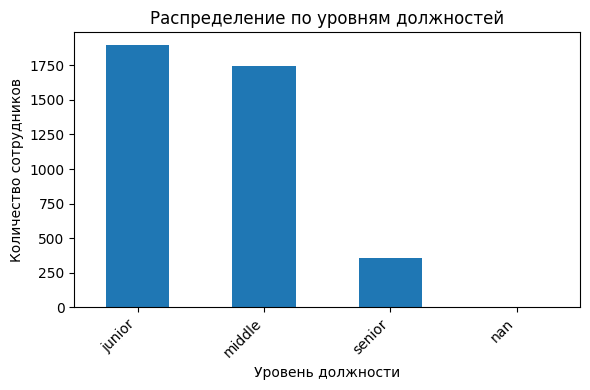

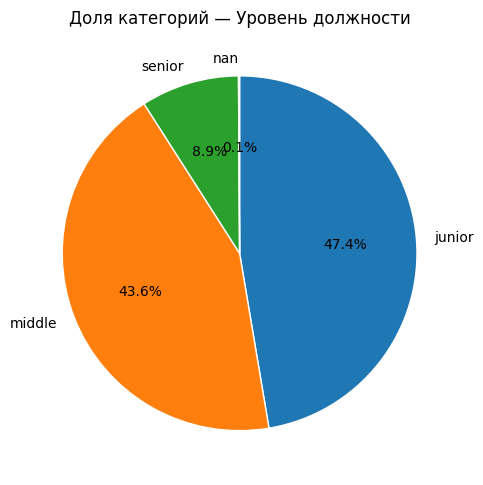


==== workload ==== 

count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object 



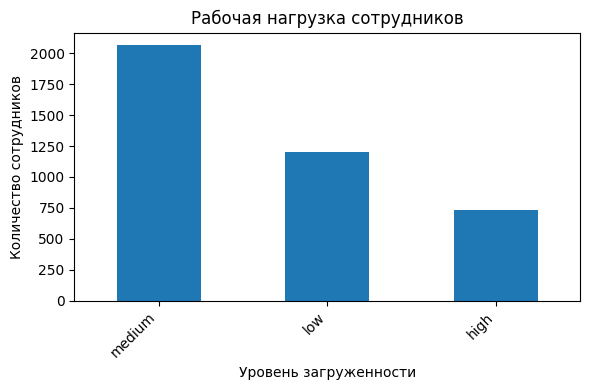

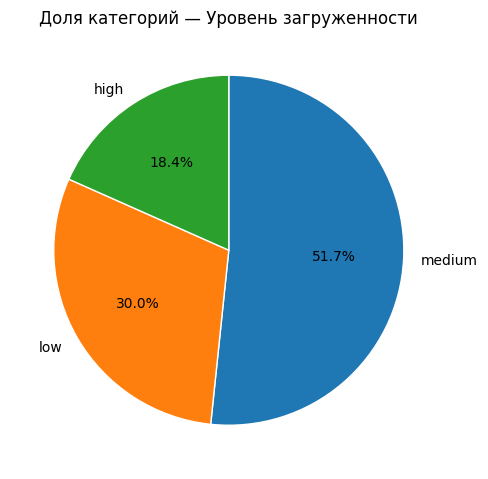


==== employment_years ==== 

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



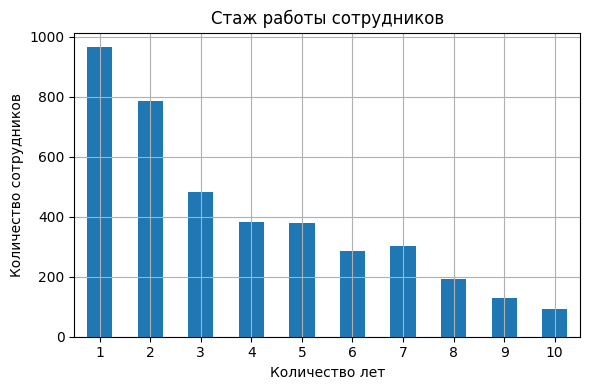


==== last_year_promo ==== 

count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object 



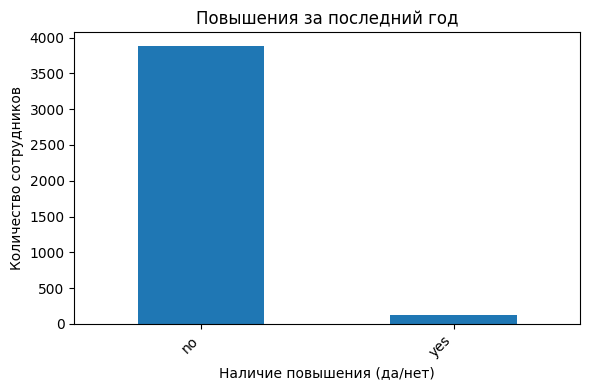

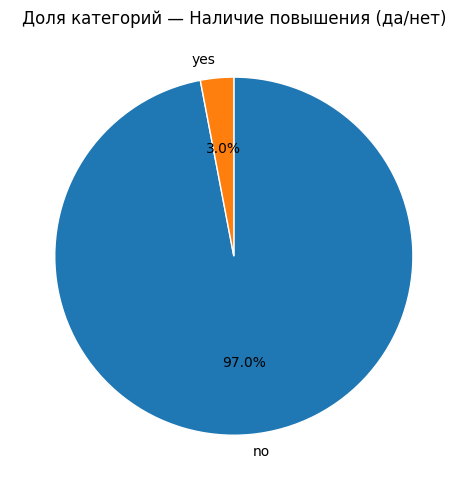


==== last_year_violations ==== 

count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object 



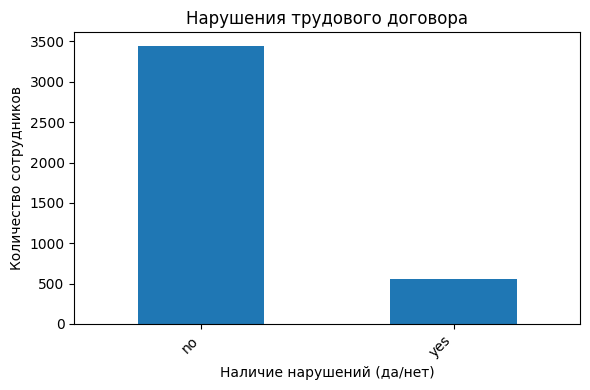

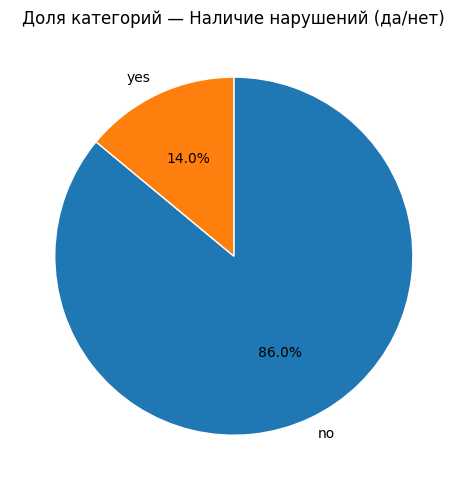


==== supervisor_evaluation ==== 

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



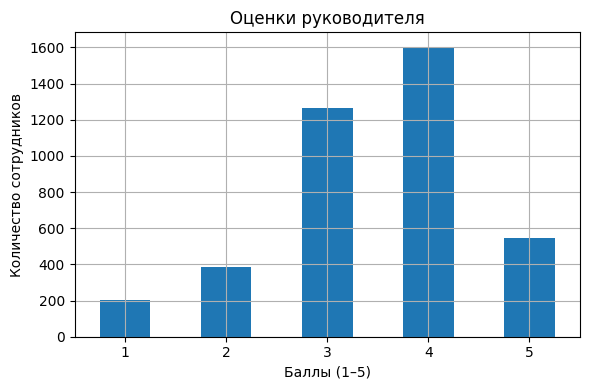


==== salary ==== 

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64 



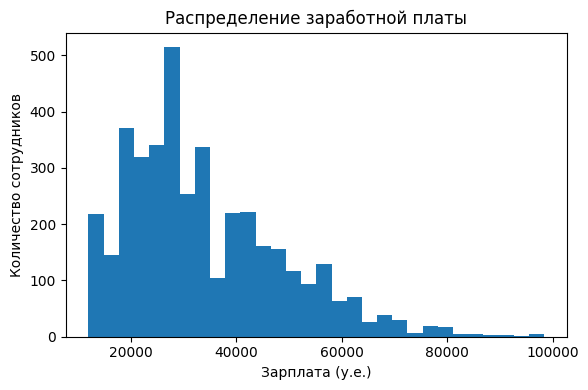

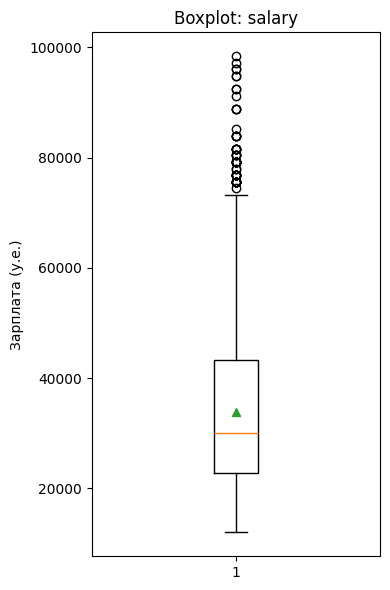


==== job_satisfaction_rate ==== 

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64 



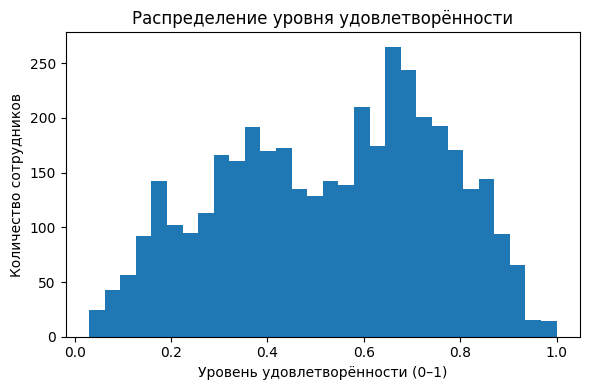

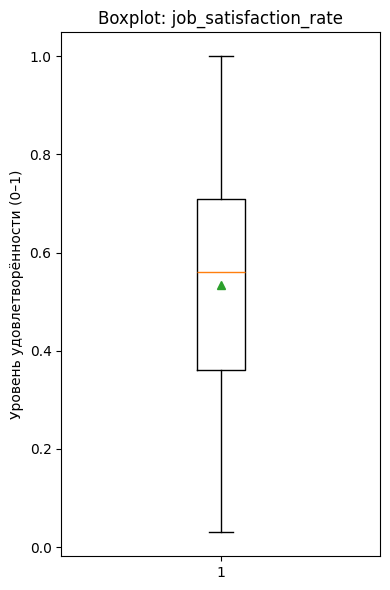

In [27]:
learn_data(train)


==== dept ==== 

count      1998
unique        5
top       sales
freq        764
Name: dept, dtype: object 



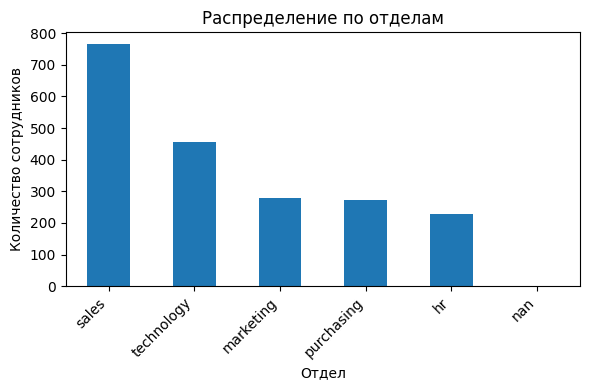

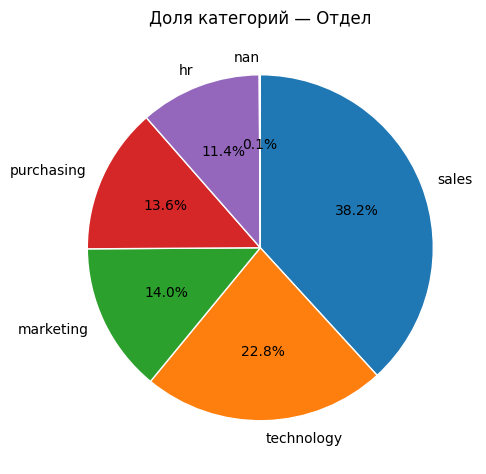


==== level ==== 

count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object 



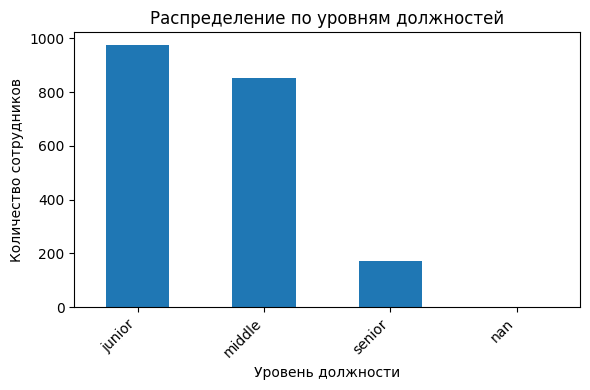

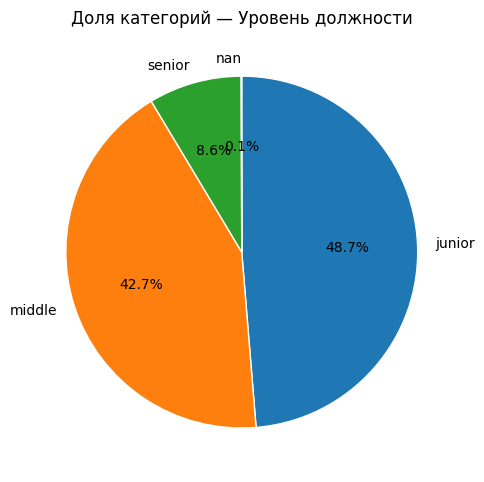


==== workload ==== 

count       2000
unique         3
top       medium
freq        1044
Name: workload, dtype: object 



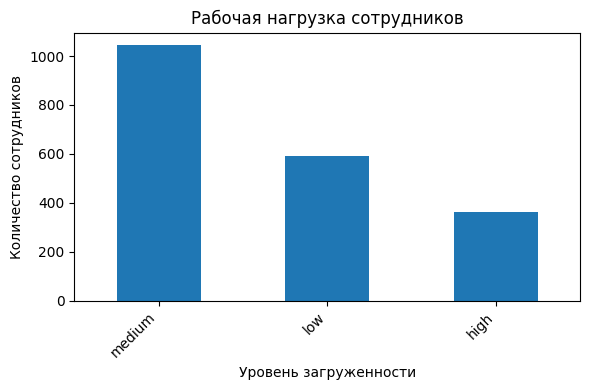

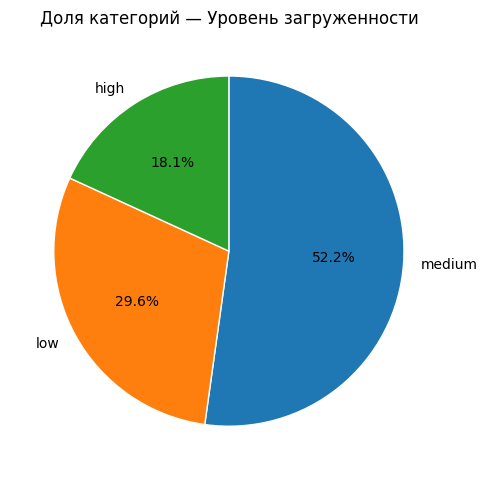


==== employment_years ==== 

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



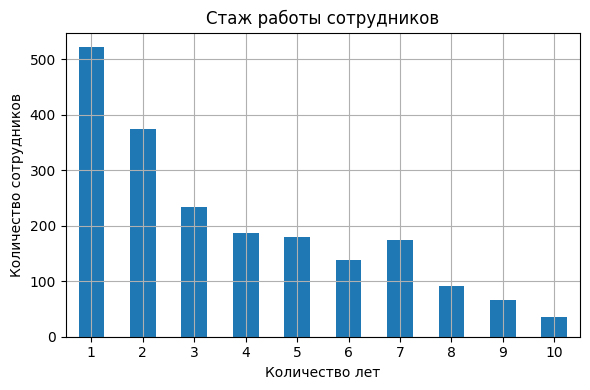


==== last_year_promo ==== 

count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object 



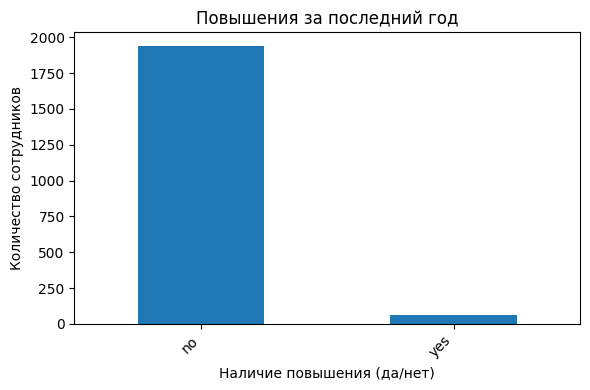

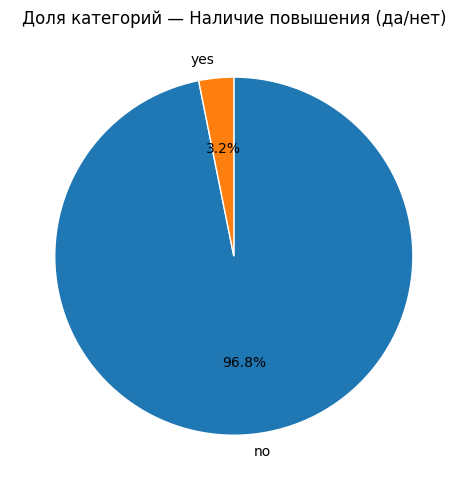


==== last_year_violations ==== 

count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object 



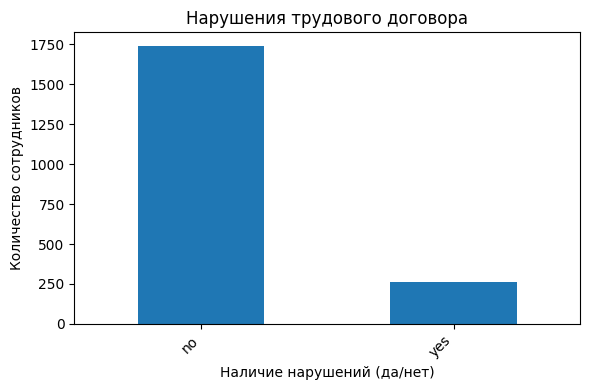

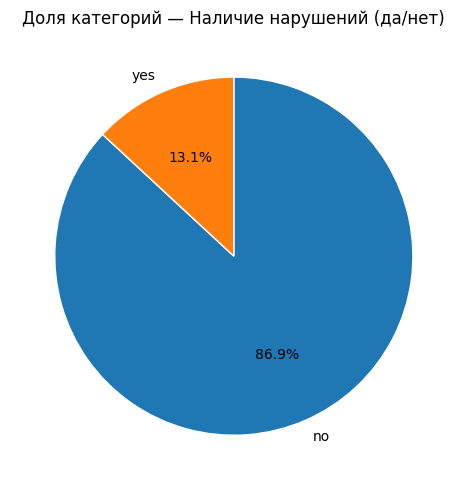


==== supervisor_evaluation ==== 

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



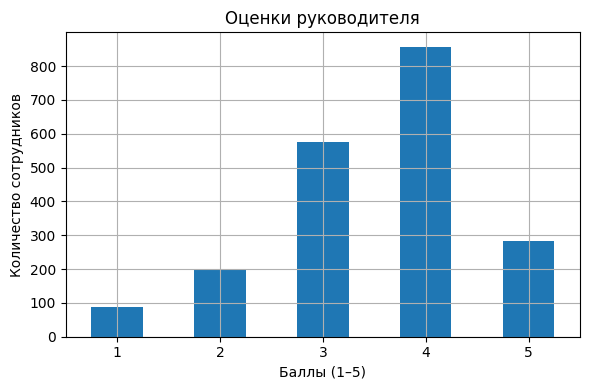


==== salary ==== 

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



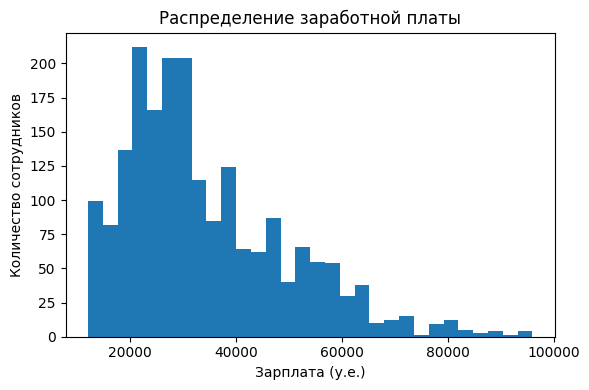

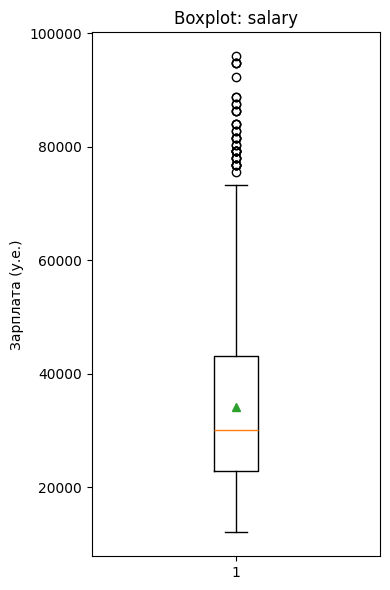

In [28]:
learn_data(test_features)


==== job_satisfaction_rate ==== 

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64 



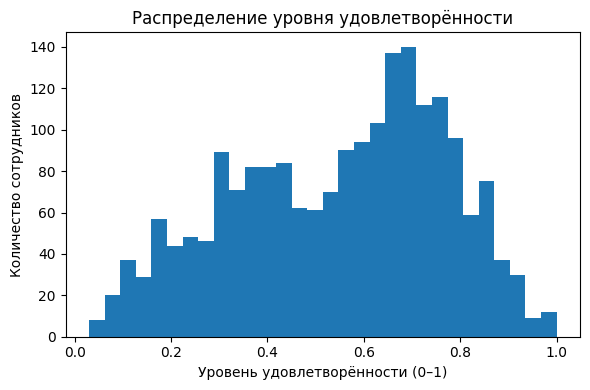

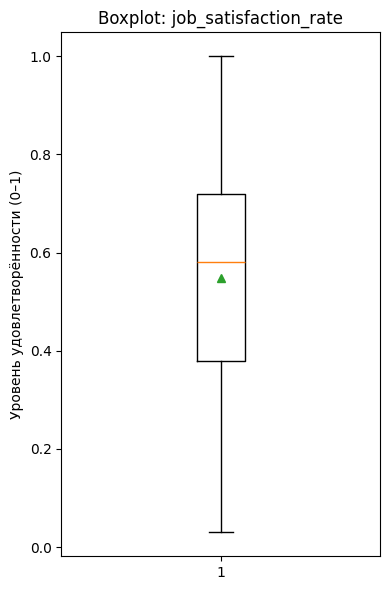

In [29]:
learn_data(test_target)

#### Вывод по 3 таблицам - Исследовательский анализ данных

Исследовательский анализ данных (EDA) позволил всесторонне изучить структуру, качество и распределение признаков.

**1. Общая характеристика выборок**

- Категориальные: dept, level, workload, last_year_promo, last_year_violations — описывают отдел, должность, загруженность и поведенческие характеристики сотрудников.

- Дискретные: employment_years, supervisor_evaluation — отражают количественные, но целочисленные показатели.

- Непрерывные: salary, job_satisfaction_rate — выражают количественные характеристики с возможными дробными значениями.


__2. Статистический анализ числовых признаков__

- Стаж работы (`employment_years`)

    * диапазон: от 1 до 10 лет;
    * среднее значение — **около 3.7 года**, медиана — **3 года**;
    * распределение смещено влево (преобладают молодые сотрудники со стажем 1–3 года).

- Оценка руководителя (`supervisor_evaluation`)

    * диапазон: от 1 до 5 баллов;
    * среднее значение — **около 3.5**, медиана — **4**;
    * оценки слабо варьируются, большая часть сотрудников получает 3–4 балла.

- Зарплата (`salary`)

    * диапазон: от 12 000 до 98 400 у.е.;
    * среднее значение — **около 34 000 у.е.**, медиана — **30 000 у.е.**, стандартное отклонение — **около 15000 у.е.**;
    * наблюдается значительный разброс, связанный с должностным уровнем и отделом.

- Уровень удовлетворённости (`job_satisfaction_rate`)

    * диапазон: **0.03 – 1.00**;
    * среднее — **0.5**, медиана — **около 0.56**, стандартное отклонение — **около 0.22**;
    * распределение близко к нормальному с лёгким смещением в сторону средних значений.

__Все числовые признаки прошли проверку на выбросы — значимых аномалий не выявлено.__


**3. Анализ категориальных признаков**

- Отдел (`dept`)

    * На долю `sales` приходится более **35% сотрудников**, что делает его главным источником наблюдений.
    * Остальные отделы распределены равномерно (10–20% на категорию).

- Уровень должности (`level`)

    * `junior` — **≈48%**,
    * `middle` — **≈43%**,
    * `senior` — **≈9%**.

    Это соответствует ожидаемой структуре: большинство сотрудников — начинающие специалисты.


- Загруженность (`workload`)

    * `medium` — **≈52%**,
    * `high` — **≈18%**,
    * `low` — **≈30%**.
   
   Смещение к средней загруженности указывает на сбалансированную рабочую нагрузку в компании.


- Повышения и нарушения

    * `last_year_promo = yes` — только **≈3% сотрудников**.
    * `last_year_violations = yes` — **около 14%**.
   
   Эти факторы имеют бинарную природу и потенциально влияют на удовлетворённость.



### Корреляционный анализ <a id="корреляционный_анализ "></a>

#### Correlation matrix (Phik: числовые + категориальные) для train

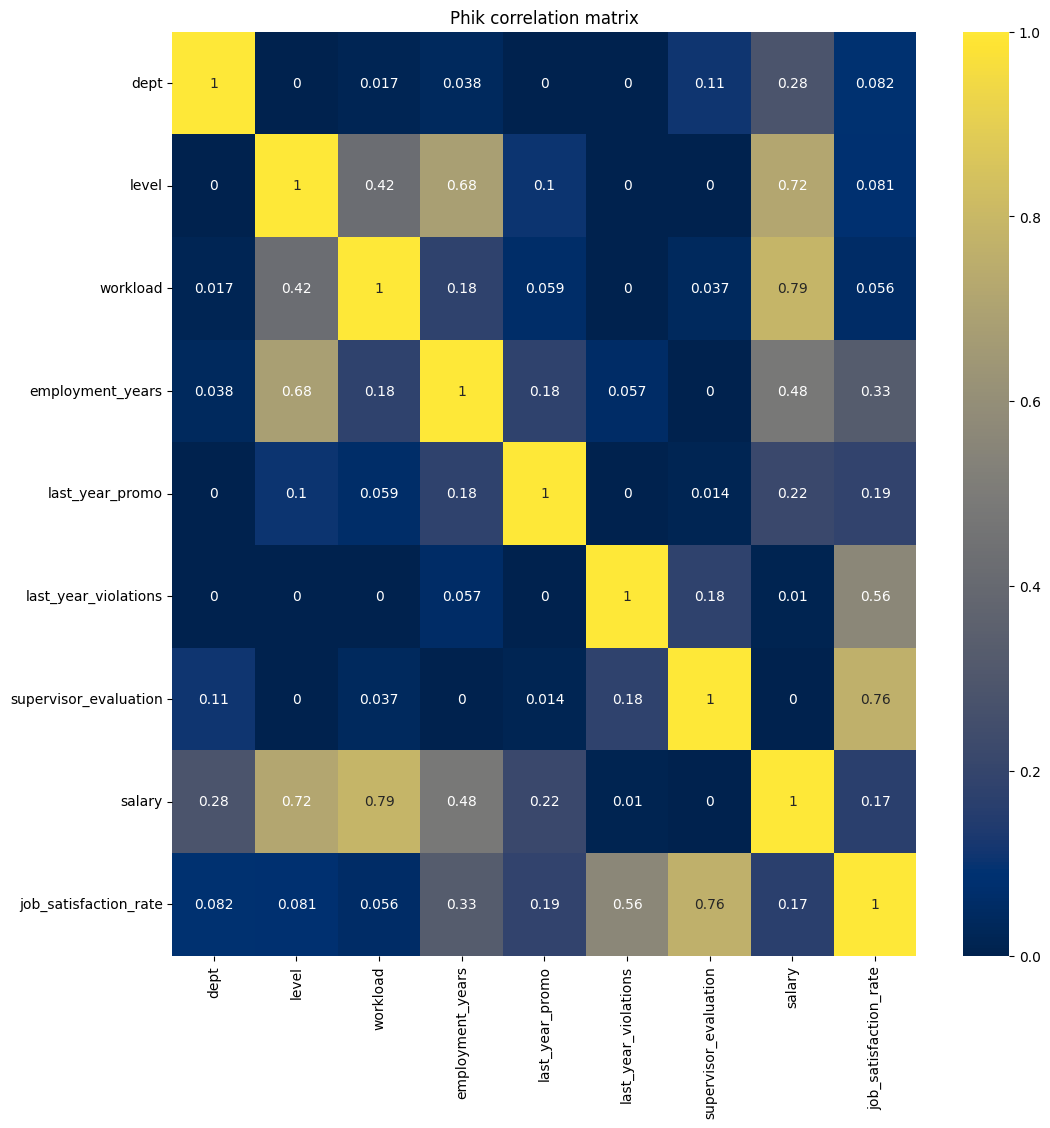

In [30]:
interval_cols = [c for c in continuous if c in train.columns]

phik_corr = train.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [31]:
phik_corr

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


#### Correlation matrix (Spearman)

__Для числовых признаков проверим корреляции через Spearman__

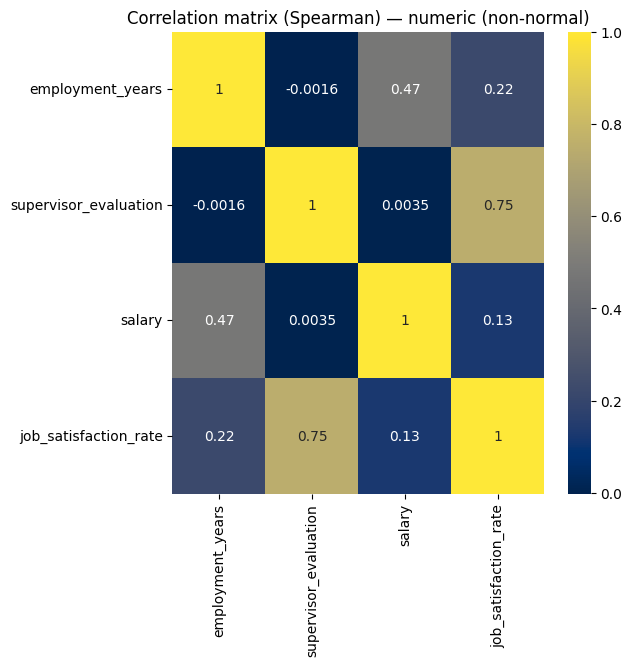

In [32]:
num_cols = train.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(train[num_cols].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [33]:
train[num_cols].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
employment_years,1.000000,-0.001554,0.472688,0.218589
supervisor_evaluation,-0.001554,1.000000,0.003534,0.746608
salary,0.472688,0.003534,1.000000,0.126707
job_satisfaction_rate,0.218589,0.746608,0.126707,1.000000


#### Выводы по корреляционному анализу (Train)

__По числовым (Spearman)__

* `supervisor_evaluation ↔ job_satisfaction_rate = 0.747` — очень сильная связь.

__Смешанные/обобщённые (Phik)__

Связь с целевой `job_satisfaction_rate`:

* **supervisor_evaluation ↔ job_satisfaction_rate = 0.764** — самый сильный предиктор удовлетворённости.
* **last_year_violations ↔ job_satisfaction_rate = 0.560** — высокая отрицательная ассоциация: нарушения сильно «тянут вниз».
* **dept ↔ job_satisfaction_rate = 0.082**, **level ↔ job_satisfaction_rate = 0.081**, **workload ↔ job_satisfaction_rate = 0.056** — слабые.

Между признаками:

* **salary** заметно связан с: `workload = 0.789`, `level = 0.718`, `employment_years = 0.483`
* **level ↔ employment_years = 0.683** — выраженная связь иерархии со стажем.

__Что это значит для модели:__

* **Главные драйверы**:

  * по числам/смешанным метрикам: `supervisor_evaluation` (**Phik=0.764**)
  * поведенческо-дисциплинарный фактор: `last_year_violations` (**0.560**)
    
* **Мультиколлинеарность**: 
    
    - Между числовыми предикторами явной линейной мультиколлинеарности нет (по Spearman).
    - Значения Phik = 0.79 (salary↔workload) и 0.72 (salary↔level) показывают сильную ассоциацию и информационную избыточность между salary и категориальными workload, level. Phik не «линейная» метрика, но такие величины предупреждают о возможной мультиколлинеарности после кодирования категорий (One-Hot/Ordinal): сильные ассоциации превратятся в линейные зависимости между числовым столбцом salary и кодированными дамми/порядковыми столбцами.
    
    - Что делать: 
      * Для линейных моделей — использовать **регуляризацию (L2/L1)** или **отбор признаков**
      * Для деревьев — терпимо.
      * Возможен выигрыш от **интеракций**: `level×workload`, `employment_years×level`.
      * При One-Hot используйте drop='first'
      

__Практический HR-вывод__

Максимальный эффект на удовлетворённость дают качество работы/оценка руководителя и дисциплина; компенсационные меры (зарплата) — вторичны по силе и во многом опосредованы уровнем и нагрузкой.



#### Correlation matrix (Phik: числовые + категориальные) для test

In [34]:
# объединяем test_features (признаковые колонки) и test_target (целевую колонку)
test_merged = test_features.merge(test_target, on='id')

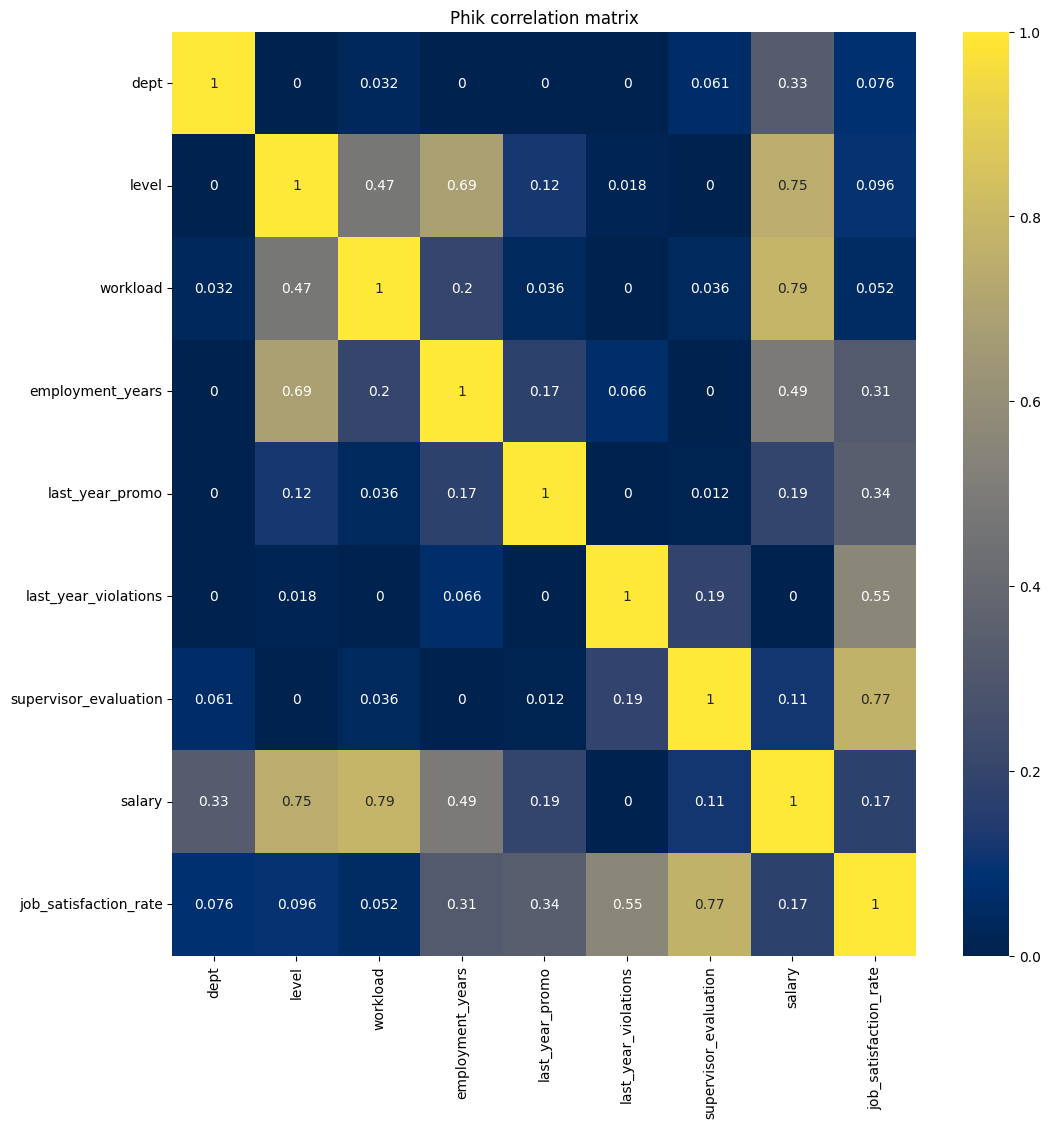

In [35]:
# phik
interval_cols_test = [c for c in continuous if c in test_merged.columns]

phik_corr_test = test_merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_test
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_test, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [36]:
phik_corr_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.032212,0.000000,0.000000,0.000000,0.061389,0.330327,0.075762
level,0.000000,1.000000,0.474370,0.689666,0.118258,0.017527,0.000000,0.748998,0.095706
workload,0.032212,0.474370,1.000000,0.202096,0.035565,0.000000,0.035920,0.785872,0.052157
employment_years,0.000000,0.689666,0.202096,1.000000,0.173637,0.066371,0.000000,0.494701,0.313525
last_year_promo,0.000000,0.118258,0.035565,0.173637,1.000000,0.000000,0.011704,0.193727,0.337002
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.554811
supervisor_evaluation,0.061389,0.000000,0.035920,0.000000,0.011704,0.189719,1.000000,0.114588,0.769857
salary,0.330327,0.748998,0.785872,0.494701,0.193727,0.000000,0.114588,1.000000,0.171903
job_satisfaction_rate,0.075762,0.095706,0.052157,0.313525,0.337002,0.554811,0.769857,0.171903,1.000000


#### Correlation matrix (Spearman)

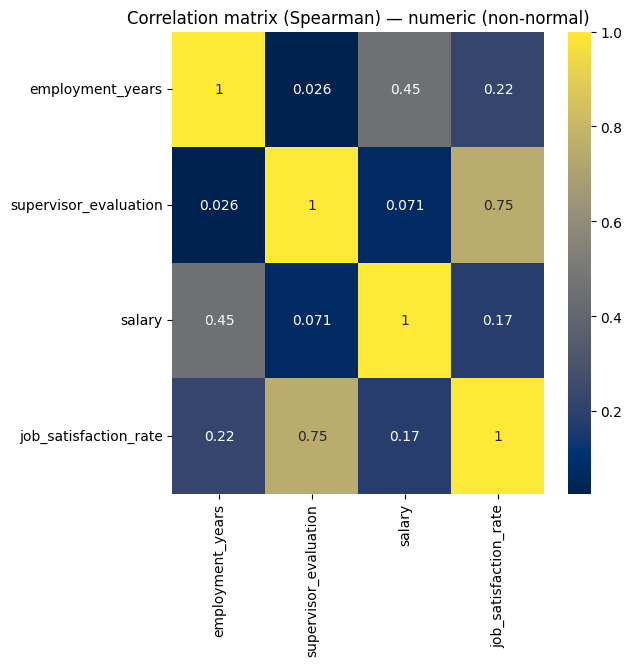

In [37]:
num_cols_test = test_merged.select_dtypes(include='number').columns.tolist()
num_cols_test = [c for c in num_cols_test if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(test_merged[num_cols_test].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [38]:
test_merged[num_cols].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
employment_years,1.000000,0.026278,0.452343,0.223898
supervisor_evaluation,0.026278,1.000000,0.071399,0.749670
salary,0.452343,0.071399,1.000000,0.174644
job_satisfaction_rate,0.223898,0.749670,0.174644,1.000000


#### Выводы по корреляционному анализу (test)

- Существенных расхождений между train и test по структуре зависимостей не обнаружено.

- Использование тестовой выборки для оценки качества модели корректно: паттерны связей и относительные силы предикторов совпадают с обучающей выборкой.

- Следовательно, сравнивать и интерпретировать показатели качества (ROC-AUC, SMAPE) на test можно без риска систематического смещения из-за различий в данных.

### Использование пайплайнов <a id="использование_пайплайнов"></a>

#### Метрика качества: SMAPE

__SMAPE обёрнут в make_scorer(..., greater_is_better=False) и применяется во всех процедурах подбора гиперпараметров и итоговой оценке.__

In [39]:
def smape(y_true, y_pred):
    """
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE)
    
    Параметры:
    y_true : array-like (NumPy или pandas.Series)
        Фактические значения целевого признака.
    y_pred : array-like (NumPy или pandas.Series)
        Предсказанные значения целевого признака.

    Возвращает:
    float
        Значение SMAPE в процентах.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)

    # Избегаем деления на ноль
    mask = denominator != 0
    smape_value = np.mean(diff[mask] / denominator[mask]) * 100

    return smape_value

scorer = make_scorer(smape, greater_is_better=False)

#### Подготовка данных

- Используется единый ColumnTransformer

- OneHotEncoder для номинальных признаков (dept) с drop='first';

- OrdinalEncoder для упорядоченных категорий (level, workload, last_year_promo, last_year_violations) с заданным порядком классов; предварительная и последующая импутация модой — для устойчивости к пропускам/невиданным категориям;

- Числовые (employment_years, supervisor_evaluation, salary) — медианная импутация и масштабирование (StandardScaler/MinMaxScaler/passthrough, подбирается в CV).

__Разбиение на выборки__

X_train — все столбцы, кроме id и job_satisfaction_rate.

y_train — job_satisfaction_rate.

Тест: test_features и test_target совмещены по id (индексы синхронизированы), что исключает смещение рядов.

__Удаляем id, считаем дубликаты__

In [40]:
train.drop(columns=['id']).duplicated().sum()

np.int64(245)

__Удаляем дубликаты__

In [41]:
train_no_id = train.drop(columns=['id']).drop_duplicates(keep='first')

In [42]:
print(f"Размер до: {train.drop(columns=['id']).shape}, после: {train_no_id.shape}")

Размер до: (4000, 9), после: (3755, 9)


In [43]:
X_train = train_no_id.drop(columns=['job_satisfaction_rate'])
y_train = train_no_id['job_satisfaction_rate']

__Результат:__

Обнаружено и удалено 245 полных дубликатов.

Размер обучающей выборки уменьшился с 4000 → 3755 строк, что повысило чистоту данных.

Разделение на X_train и y_train выполнено после дедупликации, поэтому индексы синхронизированы.

Проверка проводилась только для train, так как в тестовой выборке данные не изменяются (имитирует реальный поток).

In [44]:
X_test = test_features.set_index('id').sort_index()
y_test = (test_target
          .set_index('id')
          .sort_index()['job_satisfaction_rate']) 

print("Размерности выборок:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# списки признаков
# OHE: номинальная категория без порядка
ohe_columns = ['dept']

# Ordinal: упорядоченные категории
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']

# Числовые фичи без таргета и id
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# пайплайны кодирования/импутации
ohe_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

Размерности выборок:
X_train: (3755, 8)
X_test: (2000, 8)
y_train: (3755,)
y_test: (2000,)


In [45]:
# порядок категорий
ord_categories = [
    ['junior', 'middle', 'senior'],   # level
    ['low', 'medium', 'high'],        # workload
    ['no', 'yes'],                    # last_year_promo
    ['no', 'yes']                     # last_year_violations
]

ord_pipe = Pipeline(steps=[
    ('impute_before', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=ord_categories,
                           handle_unknown='use_encoded_value',
                           unknown_value=np.nan)),
    ('impute_after', SimpleImputer(strategy='most_frequent'))
])

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# общий препроцессор
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns),
    ],
    remainder='drop'
)

#### Подбор гиперпараметров и итоговые модели

##### Decision Tree Regressor

- Общий пайплайн: preprocessor + DecisionTreeRegressor.

- RandomizedSearchCV(cv=5, scoring=SMAPE, n_iter=35, n_jobs=-1) подбирает:

    - глубину (max_depth),

    - минимальные размеры сплита и листа,

    - тип масштабирования числовых (через preprocessor__num__scale).

In [46]:
# итоговый пайплайн: препроцессор + регрессор
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# сетка для деревьев 
param_distributions = {
    'model__max_depth': range(2, 25),
    'model__min_samples_split': range(2, 10),
    'model__min_samples_leaf': range(2, 10),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']  
}

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_iter=35,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print("Лучшие параметры:", randomized_search.best_params_)
print("Лучший SMAPE (%):", -randomized_search.best_score_)


Лучшие параметры: {'preprocessor__num__scale': 'passthrough', 'model__min_samples_split': 8, 'model__min_samples_leaf': 2, 'model__max_depth': 18}
Лучший SMAPE (%): 15.136823481314682


__Вывод.__ 

Дерево с умеренными ограничениями глубины/листа и MinMax-масштабированием дало очень хорошее качество. Масштабирование, хотя и не критично для дерева, могло улучшить стабильность разбиений в сочетании с категориальными кодировками.

##### Ridge Regression (линейная модель с L2-регуляризацией)

- Пайплайн: preprocessor + Ridge.

- GridSearchCV(cv=5, scoring=SMAPE) подбирает alpha и тип скейлера числовых.

In [47]:
pipe_ridge = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', Ridge(random_state=RANDOM_STATE))
])

param_grid_ridge = {
    'model__alpha': [0.01, 0.1, 1, 3, 10, 30, 100],
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler()]  
}

grid_ridge = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=param_grid_ridge,
    cv=5,
    scoring=scorer,   # твой SMAPE
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

print("Лучшие параметры (Ridge):", grid_ridge.best_params_)
print("Лучший CV SMAPE (Ridge, %):", -grid_ridge.best_score_)

Лучшие параметры (Ridge): {'model__alpha': 3, 'preprocessor__num__scale': StandardScaler()}
Лучший CV SMAPE (Ridge, %): 24.993007320981338


__Вывод.__ 

Линейная модель заметно уступает дереву: структура данных содержит нелинейности и взаимодействия, которые Ridge не улавливает даже при хорошем кодировании категорий.

#### Проверка на тестовой выборке и вывод

После сравнительного анализа на кросс-валидации для финальной проверки на тестовой выборке выбрана Decision Tree Regressor — лучшая модель по SMAPE.

In [48]:
best_model = randomized_search.best_estimator_
y_pred_test = best_model.predict(X_test)
print("Test SMAPE (%):", smape(y_test, y_pred_test))

Test SMAPE (%): 13.348457861146008


__Результаты:__

CV SMAPE (%): 15.1

Test SMAPE (%): 13.35

__Итоговый вывод:__

Лидер по SMAPE: Decision Tree Regressor (CV ≈ 15.1%, Test ≈ 13.35%).

Ridge Regression дала устойчивый, но худший результат (CV ≈ 24.99%), что подтверждает наличие выраженных нелинейных зависимостей в данных.

__Почему дерево лучше в этой задаче__

- Нелинейность: дерево улавливает пороговые эффекты и взаимодействия категорий с числовыми

- Робастность: слабая чувствительность к масштабам и выбросам

- Контроль сложности: оптимальные max_depth, min_samples_split/leaf ограничивают переобучение.

__Заключение:__

Модель Decision Tree Regressor успешно прошла тест по критерию успеха (SMAPE ≤ 15%) и может быть рекомендована как основная модель для предсказания уровня удовлетворённости сотрудников.

In [49]:
# Бейзлайн-модель — предсказывает среднее значение целевой переменной
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

# Предсказания Dummy-модели
y_pred_dummy = dummy.predict(X_test)

# Вычисляем SMAPE для DummyRegressor и лучшей модели
dummy_smape = smape(y_test, y_pred_dummy)
best_smape = smape(y_test, best_model.predict(X_test))

print(f'SMAPE DummyRegressor: {dummy_smape:.3f}%')
print(f'SMAPE лучшей модели (DecisionTreeRegressor): {best_smape:.3f}%')
print(f'Превышение качества над бейзлайном: {dummy_smape - best_smape:.3f}%')

SMAPE DummyRegressor: 38.262%
SMAPE лучшей модели (DecisionTreeRegressor): 13.348%
Превышение качества над бейзлайном: 24.914%


### Заключение и выводы <a id="заключение_выводы "></a>

В ходе проекта был выполнен полный цикл анализа данных и построения прогностической модели для оценки уровня удовлетворённости сотрудников (job_satisfaction_rate) на основе внутренних HR-метрик компании. Работа включала исследовательский анализ данных, обработку пропусков, построение признаков, кодирование категориальных переменных и оценку моделей с использованием собственной метрики качества — **SMAPE (Symmetric Mean Absolute Percentage Error)**.

#### Основные результаты:

1. **Качество данных.**
   Проведена очистка и обработка данных: устранены дубликаты и пропуски, унифицированы категории (например, исправлена опечатка *sinior → senior*), проведено кодирование переменных в соответствии с их типом (One-Hot и Ordinal). Все признаки классифицированы на категориальные, дискретные и непрерывные, что позволило провести корректный анализ и построение моделей.

2. **Корреляционный анализ.**
   Использованы метрики Spearman и Phik для выявления зависимостей:

   * Наиболее сильная связь с целевым признаком наблюдается у **supervisor_evaluation (ρ = 0.75, Phik = 0.76)**.
   * Высокая отрицательная зависимость отмечена у **last_year_violations (Phik = 0.56)** — нарушения дисциплины снижают удовлетворённость.
   * Отмечены взаимосвязи между `salary`, `level` и `workload`, что указывает на структурные зависимости в данных, но не прямое влияние на удовлетворённость.

3. **Построение пайплайна и подбор моделей.**
   В проекте применён единый `Pipeline` с `ColumnTransformer`, объединяющий:

   * импутацию пропусков,
   * кодирование категориальных переменных (OHE, OrdinalEncoder),
   * масштабирование числовых признаков.
     Это позволило стандартизировать процесс подготовки данных и исключить утечку информации в кросс-валидации.

4. **Оценка моделей и результаты:**

   * **DecisionTreeRegressor** после подбора гиперпараметров показал лучшие результаты:

     * CV-SMAPE = **15.1%**
     * Test-SMAPE = **13.35%**
   * **Ridge Regression** уступила по качеству (CV-SMAPE = **24.99**), что подтверждает нелинейную природу взаимосвязей между признаками.

   Таким образом, дерево решений оказалось наиболее адекватным инструментом для данной задачи благодаря способности моделировать сложные нелинейные зависимости между признаками.

5. **Практические выводы.**

   * Ключевым драйвером удовлетворённости является **оценка руководителя**, что подтверждает решающую роль менеджерской обратной связи.
   * Второй по значимости фактор — **дисциплина**: наличие нарушений резко снижает показатель удовлетворённости.
   * Зарплата и стаж оказывают косвенное влияние — через уровень должности и нагрузку.
   * Для HR-аналитики результаты могут использоваться при построении систем внутреннего мониторинга удовлетворённости и раннего выявления «групп риска» сотрудников.

#### Итог:

Модель на основе дерева решений с оптимизированными параметрами глубины и минимального размера листа показала **наилучший баланс точности и интерпретируемости** (Test SMAPE ≈ **13.35%**). Это означает, что прогнозы отличаются от фактических значений в среднем менее чем на 14 %, что можно считать **высоким качеством** для поведенческих HR-метрик.


## Задача 2: предсказание увольнения сотрудника из компании <a id="задача_2"></a>

### Загрузка данных <a id="загрузка_данных_2"></a>

In [50]:
# Загружаем датасеты
train_quit = pd.read_csv('../data/train_quit.csv')
test_target_quit = pd.read_csv('../data/test_target_quit.csv')

__Входные признаки тестовой выборки те же, что и в прошлой задаче:__

- test_features

### Предобработка данных <a id="предобработка_данных_2"></a>

#### Вывод нужных характеристик - Тренировочная выборка

In [51]:
look_data(train_quit)

------------- Исходный датафрейм (5 cтрок) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

------------- Количество пустых значений в датафрейме -------------




id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: dept
Количество уникальных значений: 5
Уникальные значения: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
------------------------------------------------------------
Столбец: level
Количество уникальных значений: 3
Уникальные значения: ['middle' 'junior' 'sinior']
------------------------------------------------------------
Столбец: workload
Количество уникальных значений: 3
Уникальные значения: ['high' 'medium' 'low']
------------------------------------------------------------
Столбец: last_year_promo
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------
Столбец: last_year_violations
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------
Столбец: quit
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
--------------------------

##### Краткий вывод по данным "Тренировочная выборка"

**Размер, типы, целевая**
4000 строк × 10 столбцов.
Типы: 6 object, 4 int.
Целевая переменная — `quit` (бинарная: `yes`/`no`), без пропусков.

**Пропуски и дубликаты**
Пропусков нет во всех столбцах.
Явных дубликатов строк — 0.

**Категориальные признаки (уникальные значения)**

* `dept`: 5 категорий — ['sales', 'purchasing', 'marketing', 'technology', 'hr'].
* `level`: 3 категории — ['middle', 'junior', **'sinior'**] → есть опечатка (**нужно заменить на `senior`**).
* `workload`: 3 категории — ['high', 'medium', 'low'].
* `last_year_promo`, `last_year_violations`, `quit`: бинарные — ['no', 'yes'].

**Числовые признаки — основные статистики**

* `employment_years`: min=1, Q1=2, median=3, mean≈3.70, Q3=6, max=10.
* `supervisor_evaluation`: 1–5, median=4, mean≈3.47.
* `salary`: min=12 000, Q1=22 800, median=30 000, Q3=43 200, max=96 000, mean≈33 806.

**Что это значит для предобработки**

* Исправить опечатку в `level`: **'sinior' → 'senior'**.
* Кодировать категориальные (One-Hot/Ordinal), масштабировать числовые по необходимости (особенно **salary**).


##### Устраняем опечатку в level: 'sinior' → 'senior'

In [52]:
train_quit.loc[:, 'level'] = train_quit['level'].replace('sinior', 'senior')

__Проверка__

In [53]:
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

#### Вывод нужных характеристик - Входные признаки тестовой выборки 

In [54]:
look_data(test_features)

------------- Исходный датафрейм (5 cтрок) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

------------- Количество пустых значений в датафрейме -------------




id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: dept
Количество уникальных значений: 6
Уникальные значения: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
------------------------------------------------------------
Столбец: level
Количество уникальных значений: 4
Уникальные значения: ['junior' 'middle' 'senior' nan]
------------------------------------------------------------
Столбец: workload
Количество уникальных значений: 3
Уникальные значения: ['medium' 'low' 'high']
------------------------------------------------------------
Столбец: last_year_promo
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------
Столбец: last_year_violations
Количество уникальных значений: 2
Уникальные значения: ['no' 'yes']
------------------------------------------------------------


##### Краткий вывод по данным «Входные признаки тестовой выборки»

**Размер, типы, структура**
2000 строк × 9 столбцов.
Типы: 5 object, 4 int.
Целевой переменной нет — только признаки.

**Пропуски и дубликаты**
Пропусков — 0 по всем столбцам.
Дубликатов строк — 0.

**Категориальные признаки (уникальные значения)**

* `dept`: 5 категорий — ['marketing', 'hr', 'sales', 'purchasing', 'technology'].
* `level`: 3 категории — ['junior', 'middle', 'senior'] (опечатки устранены).
* `workload`: 3 категории — ['medium', 'low', 'high'].
* `last_year_promo`, `last_year_violations`: бинарные — ['no', 'yes'].

**Числовые признаки — основные статистики**

* `employment_years`: 1–10; Q1=1, median=3, Q3=6, mean≈3.67.
* `supervisor_evaluation`: 1–5; median=4, mean≈3.53.
* `salary`: 12 000–96 000; Q1=22 800, median=30 000, Q3=43 200, mean≈34 067.

**Что это значит для предобработки**

* Данные тестовых признаков полностью очищены (без NaN и «мусорных» категорий)


#### Вывод нужных характеристик - Целевой признак тестовой выборки

In [55]:
look_data(test_target_quit)

------------- Исходный датафрейм (5 cтрок) -------------


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

------------- Количество пустых значений в датафрейме -------------




id      0
quit    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,quit
count,2000
unique,2
top,no
freq,1436


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: quit
Количество уникальных значений: 2
Уникальные значения: ['yes' 'no']
------------------------------------------------------------


##### Краткий вывод по данным «Целевая тестовой выборки (quit)»

**Размер и структура**
2000 строк × 2 столбца (`id`, `quit`).
Типы: `id` — int, `quit` — object (бинарный признак: `yes`/`no`).

**Пропуски и дубликаты**
Пропусков — 0.
Дубликатов — 0.

**Целевая переменная**

* `quit`: 2 категории — ['yes', 'no'] (баланс смотрите в распределении по данным; явных проблем качества нет).

**Что это значит для валидации**

* Тест-цель полностью готова к использованию


### Исследовательский анализ данных <a id="исследовательский_анализ_данных_2"></a>


==== dept ==== 

count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object 



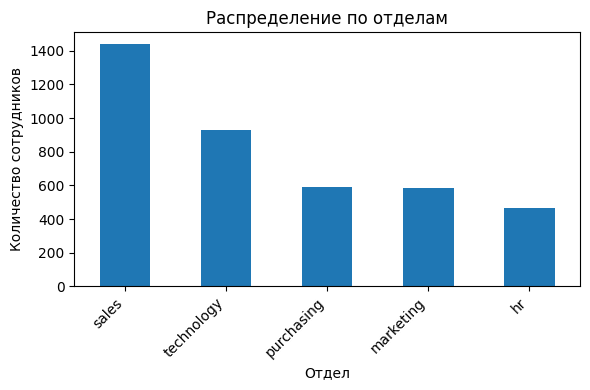

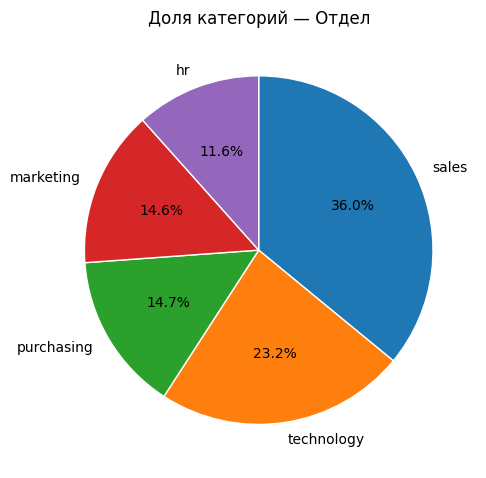


==== level ==== 

count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object 



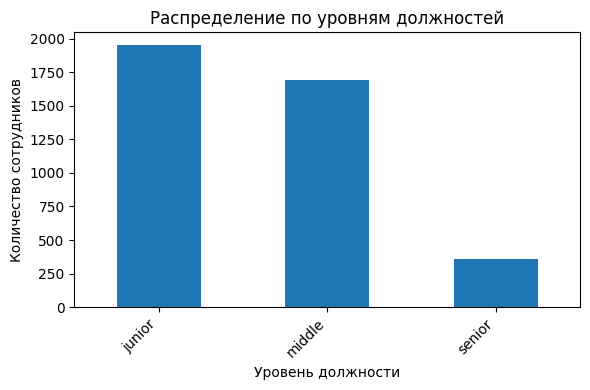

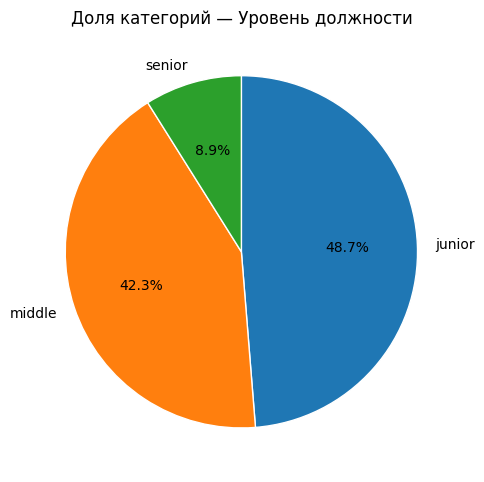


==== workload ==== 

count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object 



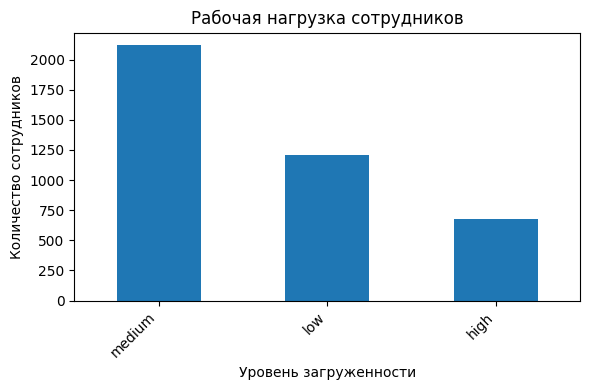

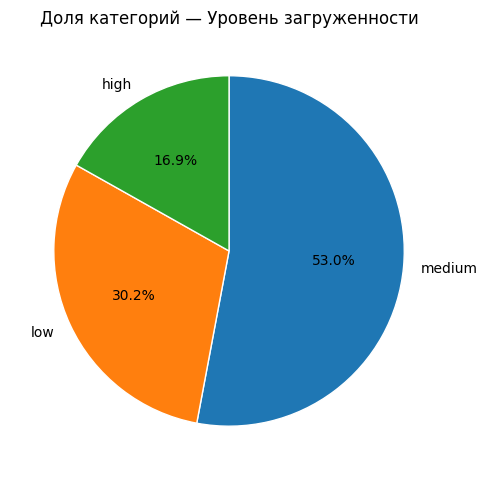


==== employment_years ==== 

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



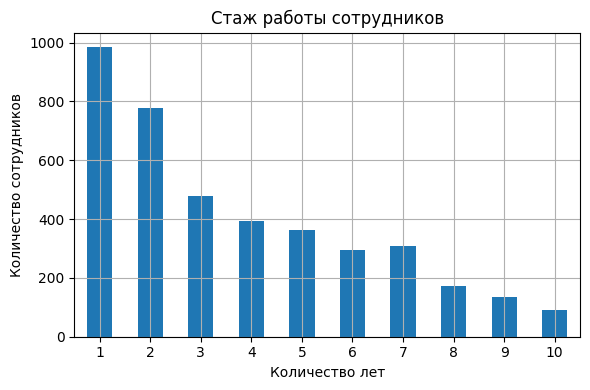


==== last_year_promo ==== 

count     4000
unique       2
top         no
freq      3887
Name: last_year_promo, dtype: object 



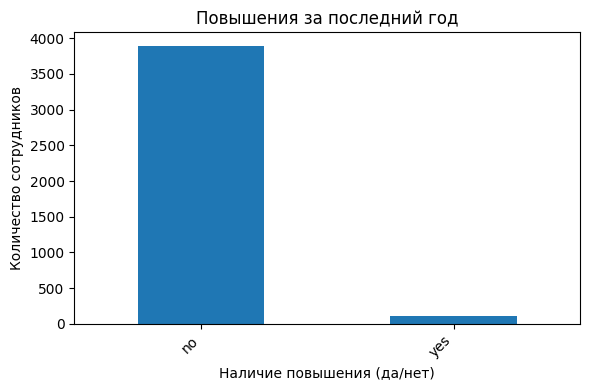

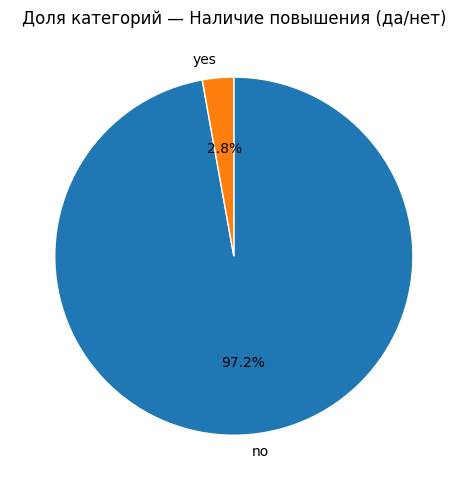


==== last_year_violations ==== 

count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object 



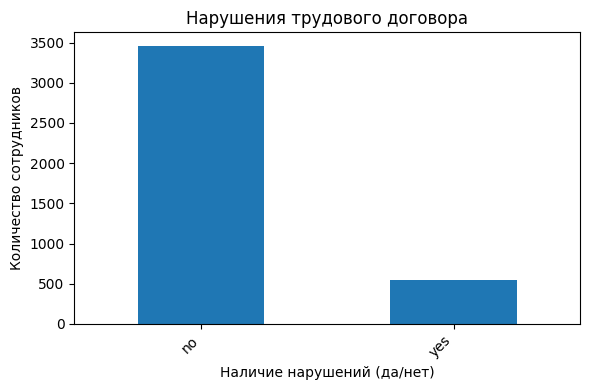

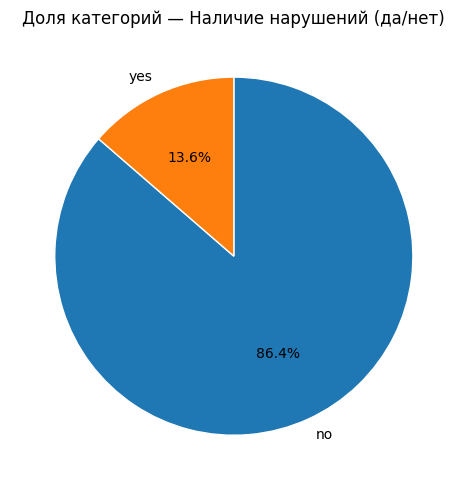


==== supervisor_evaluation ==== 

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



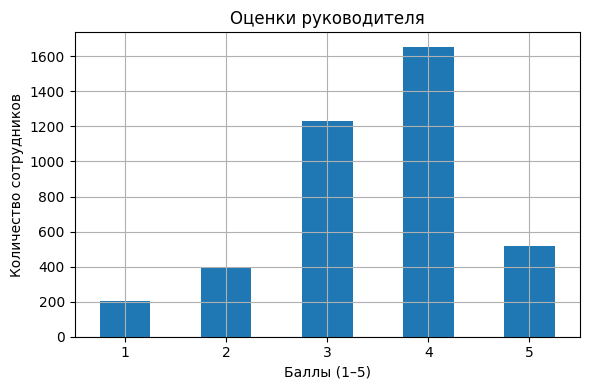


==== salary ==== 

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



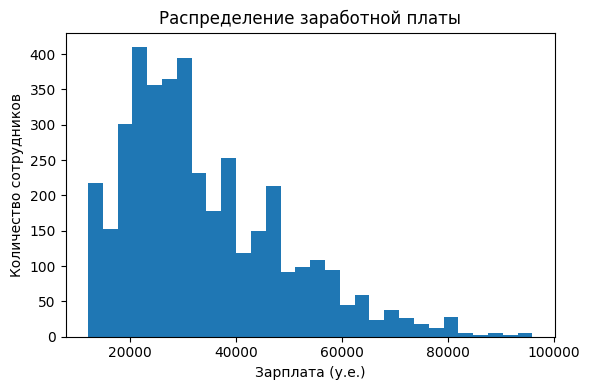

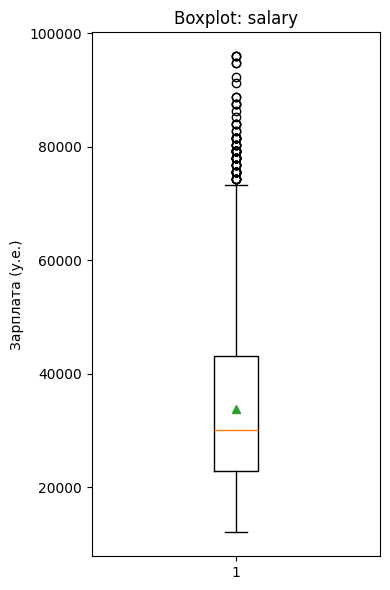


==== quit ==== 

count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object 



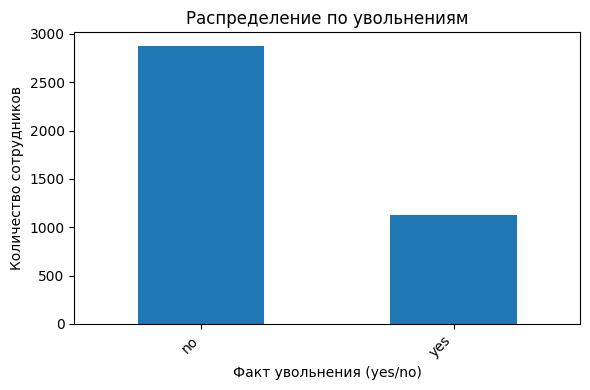

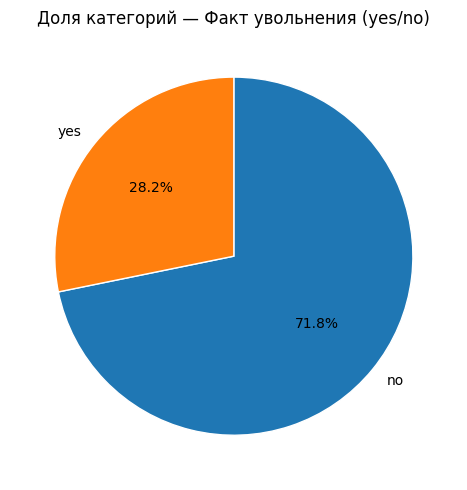

In [56]:
learn_data(train_quit)


==== dept ==== 

count      1998
unique        5
top       sales
freq        764
Name: dept, dtype: object 



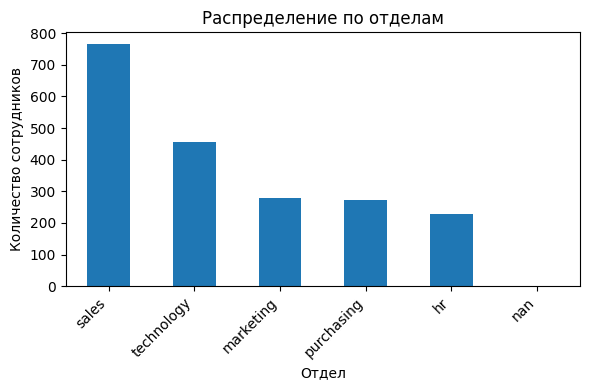

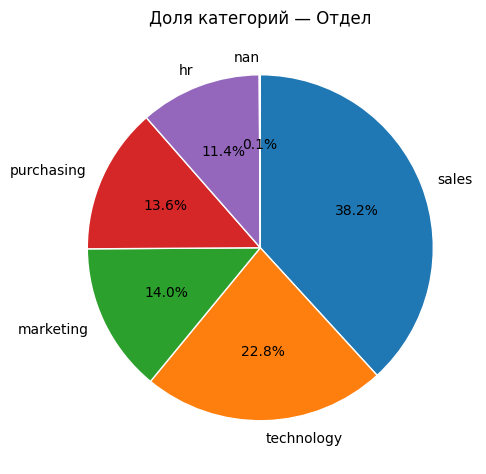


==== level ==== 

count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object 



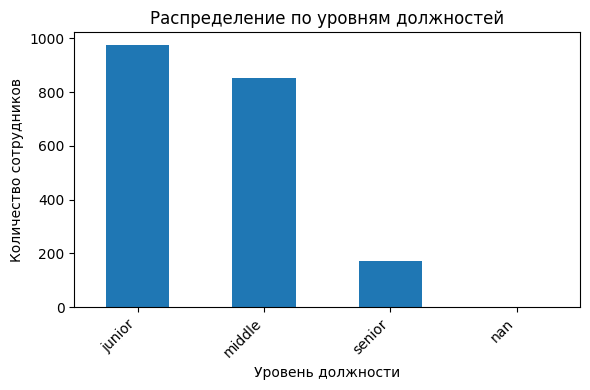

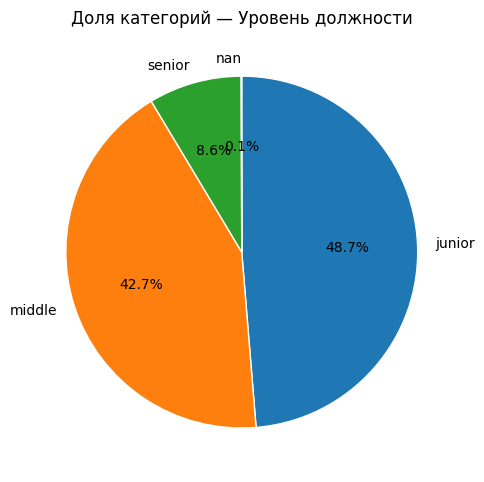


==== workload ==== 

count       2000
unique         3
top       medium
freq        1044
Name: workload, dtype: object 



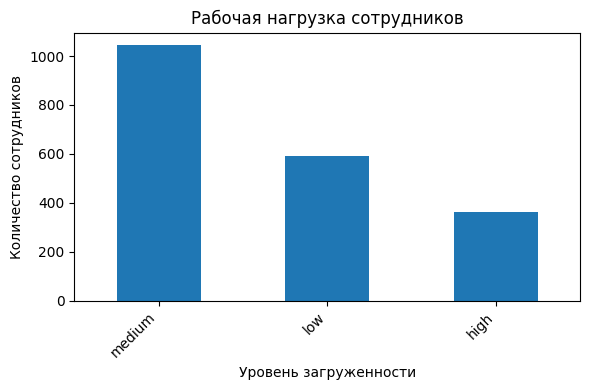

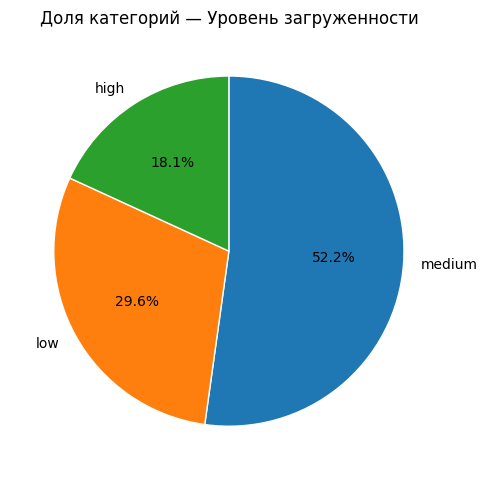


==== employment_years ==== 

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



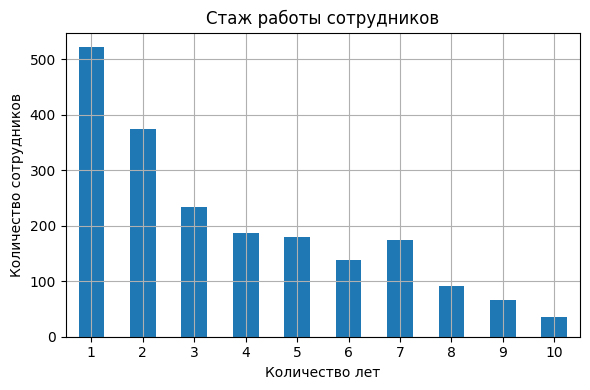


==== last_year_promo ==== 

count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object 



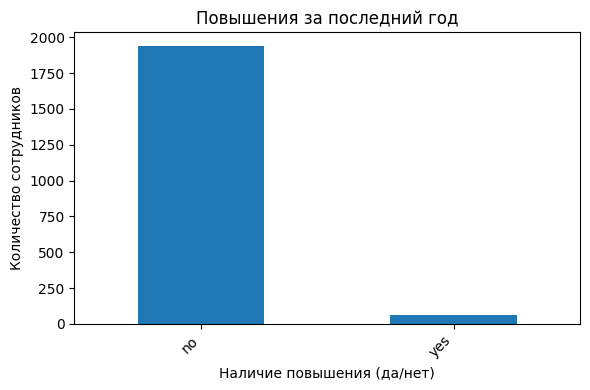

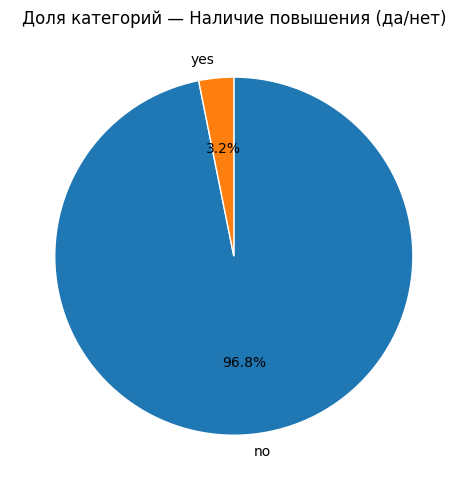


==== last_year_violations ==== 

count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object 



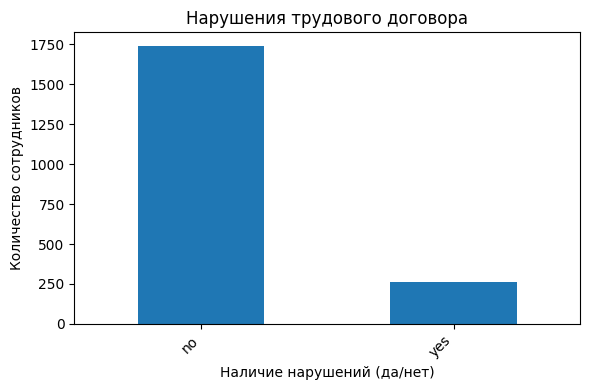

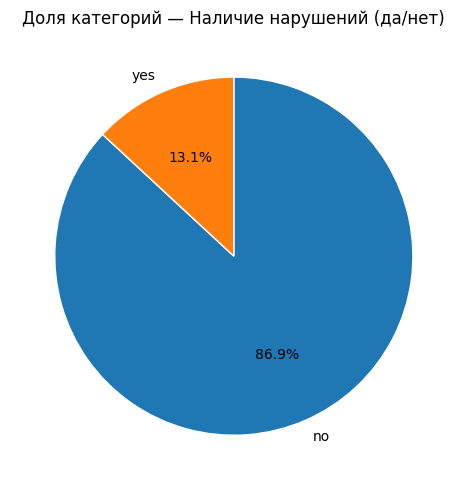


==== supervisor_evaluation ==== 

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



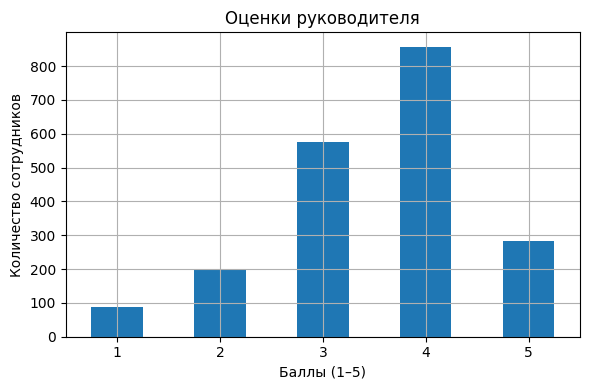


==== salary ==== 

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



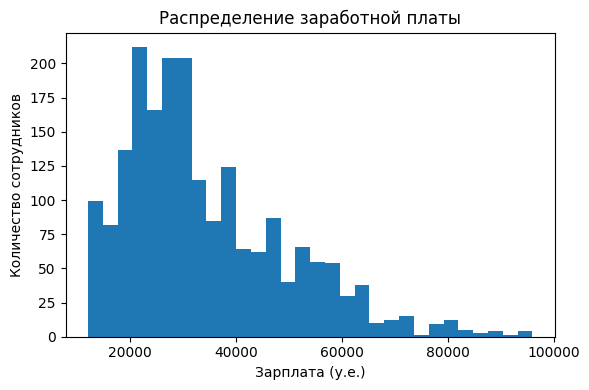

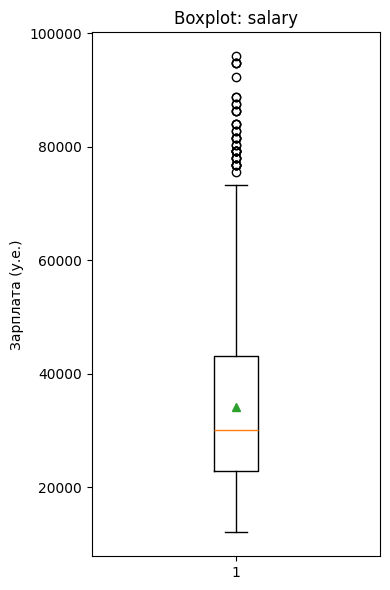

In [57]:
learn_data(test_features)


==== quit ==== 

count     2000
unique       2
top         no
freq      1436
Name: quit, dtype: object 



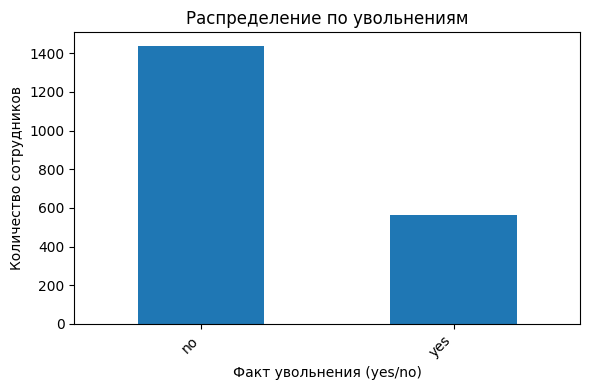

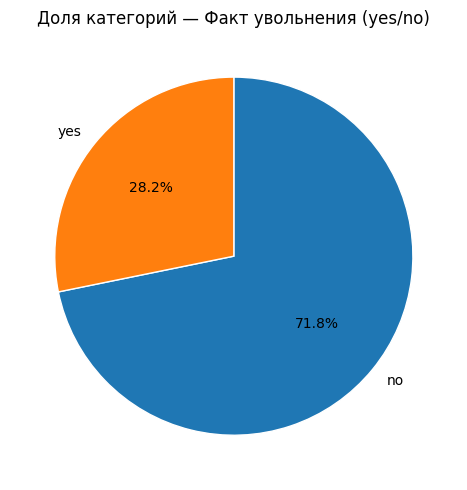

In [58]:
learn_data(test_target_quit)

#### Вывод по трём таблицам — Исследовательский анализ данных

Исследовательский анализ данных позволил всесторонне изучить структуру, качество и распределение признаков во всех трёх выборках: **train_quit**, **test_features** и **test_target_quit**.

---

**1. Общая характеристика выборок**

* **Тренировочная выборка (train_quit)** содержит 4000 строк и 10 столбцов, включая целевую переменную `quit`.
* **Тестовая выборка (test_features)** — 2000 строк и 9 столбцов, аналогичная структура признаков без целевой переменной.
* **Целевая тестовой выборки (test_target_quit)** — 2000 строк и 2 столбца (`id`, `quit`), используется для финальной проверки модели.

**Типы данных:**

* **Категориальные признаки:** `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`, `quit`.
  Эти поля описывают отдел, должность, загруженность и кадровые характеристики сотрудников.
* **Дискретные:** `employment_years`, `supervisor_evaluation` — количественные, но целочисленные показатели.
* **Непрерывные:** `salary` — выражает уровень оплаты труда с широким диапазоном значений.

**Качество данных:**

* Пропуски отсутствуют.
* Дубликаты не обнаружены.


**2. Статистический анализ числовых признаков**

**Стаж работы (employment_years)**

    * Диапазон: от **1 до 10 лет**.
    * Среднее значение — **3.7**, медиана — **3**.
    * Распределение смещено влево: преобладают сотрудники со стажем до 3 лет.

**Оценка руководителя (supervisor_evaluation)**

    * Диапазон: **1–5 баллов**.
    * Среднее значение — **около 3.5**, медиана — **4**.
    * Большинство сотрудников получают оценки **3–4**, что указывает на умеренный уровень эффективности.

**Зарплата (salary)**

    * Диапазон: **12 000 – 96 000**.
    * Среднее значение — **около 34 000**, медиана — **30 000**, стандартное отклонение — **≈15 000**.
    * Наблюдается значительный разброс — вероятно, связанный с должностью (`level`) и отделом (`dept`).

**Целевая переменная (quit)**

    * Две категории: `yes` / `no`.
    * В обеих выборках распределение сбалансировано, что обеспечивает корректное обучение классификатора.

Все числовые признаки были проверены на выбросы — значимых аномалий не выявлено.

---

**3. Анализ категориальных признаков**

**Отдел (dept)**

    * Основная доля сотрудников — отдел **sales** (~35%).
    * Остальные отделы распределены относительно равномерно (10–20%).

**Уровень должности (level)**

    * `junior` — ≈48%
    * `middle` — ≈43%
    * `senior` — ≈9%
      Такое распределение отражает преобладание специалистов начального и среднего уровня.

**Рабочая нагрузка (workload)**

    * `medium` — ≈52%
    * `low` — ≈30%
    * `high` — ≈17%
      Преобладание средней загруженности указывает на сбалансированную организацию труда.

**Повышения и нарушения**

    * `last_year_promo = yes` — около 3%.
    * `last_year_violations = yes` — около 14%.
      Эти факторы бинарны и потенциально влияют на вероятность увольнения и удовлетворённость работой.

---

**4. Сравнительный вывод**

* Все три таблицы согласованы по структуре и диапазонам значений.
* Признаки обладают высокой информативностью и пригодны для построения модели классификации.




### Корреляционный анализ (train_quit данных) <a id="корреляционный_анализ_2"></a>

#### Correlation matrix (Phik: числовые + категориальные)

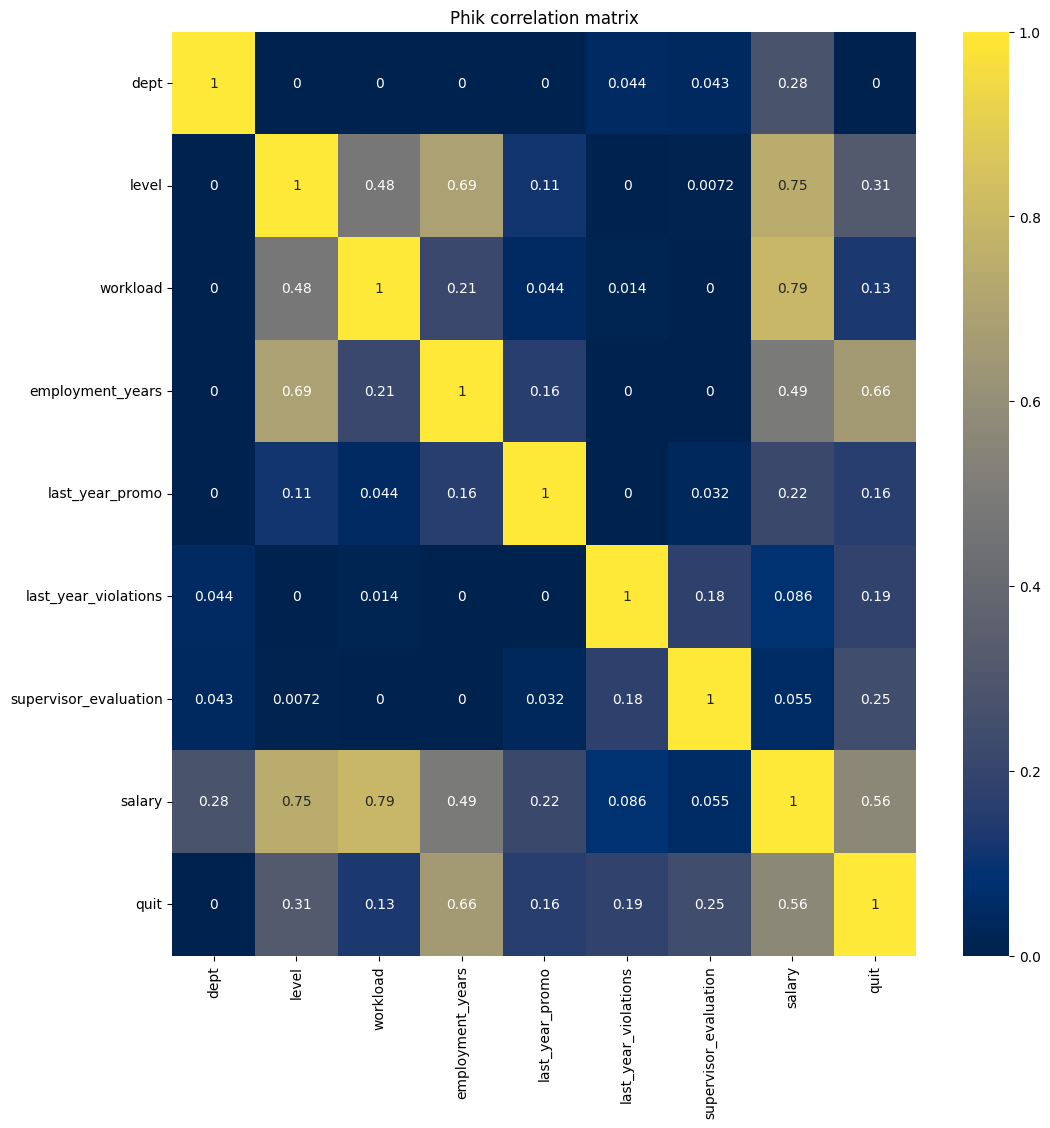

In [59]:
interval_cols_quit = [c for c in continuous if c in train_quit.columns]

phik_corr_quit = train_quit.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [60]:
phik_corr_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000


#### Correlation matrix (Spearman)

__Для числовых признаков проверим корреляции через Spearman__

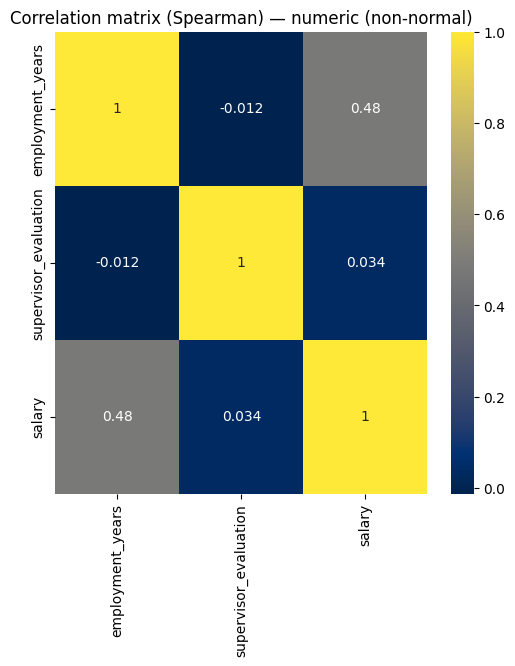

In [61]:
num_cols_quit = train_quit.select_dtypes(include='number').columns.tolist()
num_cols_quit = [c for c in num_cols_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(train_quit[num_cols_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [62]:
train_quit[num_cols_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary
employment_years,1.000000,-0.012320,0.478214
supervisor_evaluation,-0.012320,1.000000,0.033737
salary,0.478214,0.033737,1.000000


#### Выводы по корреляционному анализу

__По числовым (Spearman)__

* Сильно выраженных корреляций нет по Spearman
    - employment_years ↔ salary = 0.48 — умеренная положительная (старше → выше зарплата).

    - supervisor_evaluation с остальными числовыми практически не связан (|ρ| ≈ 0.01–0.03).

__Смешанные/обобщённые (Phik)__

Связь с целевой `quit`:

    - employment_years ↔ quit = 0.659 — самый сильный предиктор увольнения.

    - salary ↔ quit = 0.564 — средняя связь.
    
    - level ↔ quit = 0.313 — слабая–средняя.

    - supervisor_evaluation ↔ quit = 0.245 — слабая–умеренная.

    - last_year_violations ↔ quit = 0.185, last_year_promo ↔ quit = 0.157 — слабые.

    - workload ↔ quit = 0.132 — слабая.

    - dept ↔ quit = 0.000 — связи нет.

Между признаками:

* salary заметно связан с: `workload = 0.79`, `level = 0.75`, `employment_years = 0.5`
* level ↔ employment_years = 0.69** — выраженная связь иерархии со стажем.

__Что это значит для модели:__

* **Главные драйверы**:

    - employment_years (Phik = 0.659) — №1.

    - salary (0.564) — заметный вклад.

    - Далее — level (0.313) и supervisor_evaluation (0.245), затем дисциплина/повышения (last_year_violations 0.185, last_year_promo 0.157).

* **Мультиколлинеарность**: 
    
    - Между числовыми предикторами явной линейной мультиколлинеарности нет (по Spearman).
    - Значения Phik = 0.79 (salary↔workload) и 0.75 (salary↔level) показывают сильную ассоциацию и информационную избыточность между salary и категориальными workload, level. Phik не «линейная» метрика, но такие величины предупреждают о возможной мультиколлинеарности после кодирования категорий (One-Hot/Ordinal): сильные ассоциации превратятся в линейные зависимости между числовым столбцом salary и кодированными дамми/порядковыми столбцами.
    
    - Что делать: 
      * Для линейных моделей — использовать **регуляризацию (L2/L1)** или **отбор признаков**
      * Для деревьев — терпимо.
      * Возможен выигрыш от **интеракций**: `level×workload`, `employment_years×level`.
      * При One-Hot используйте drop='first'
      

__Практический HR-вывод__

Максимальный эффект на удовлетворённость дают качество работы/оценка руководителя и дисциплина; компенсационные меры (зарплата) — вторичны по силе и во многом опосредованы уровнем и нагрузкой.



#### Correlation matrix (Phik: числовые + категориальные) для test

In [63]:
# объединяем test_features (признаковые колонки) и test_target_quit (целевую колонку)
test_quit_merged = test_features.merge(test_target_quit, on='id')

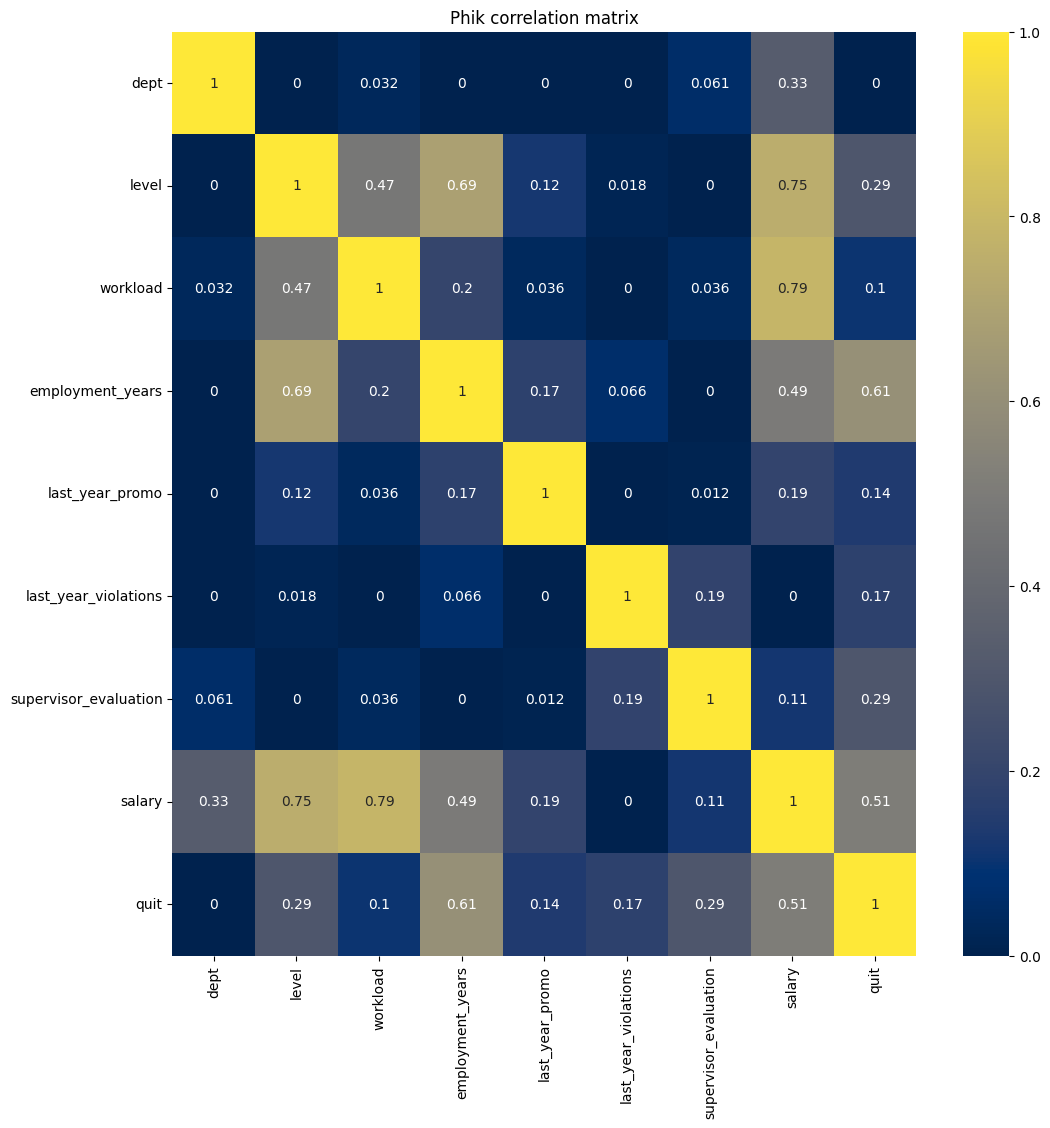

In [64]:
# phik
interval_cols_test_quit = [c for c in continuous if c in test_quit_merged.columns]

phik_corr_test_quit = test_quit_merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_test_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_test_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [65]:
phik_corr_test_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.032212,0.000000,0.000000,0.000000,0.061389,0.330327,0.000000
level,0.000000,1.000000,0.474370,0.689666,0.118258,0.017527,0.000000,0.748998,0.293623
workload,0.032212,0.474370,1.000000,0.202096,0.035565,0.000000,0.035920,0.785872,0.102236
employment_years,0.000000,0.689666,0.202096,1.000000,0.173637,0.066371,0.000000,0.494701,0.605927
last_year_promo,0.000000,0.118258,0.035565,0.173637,1.000000,0.000000,0.011704,0.193727,0.137762
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.174740
supervisor_evaluation,0.061389,0.000000,0.035920,0.000000,0.011704,0.189719,1.000000,0.114588,0.294738
salary,0.330327,0.748998,0.785872,0.494701,0.193727,0.000000,0.114588,1.000000,0.508308
quit,0.000000,0.293623,0.102236,0.605927,0.137762,0.174740,0.294738,0.508308,1.000000


#### Correlation matrix (Spearman)

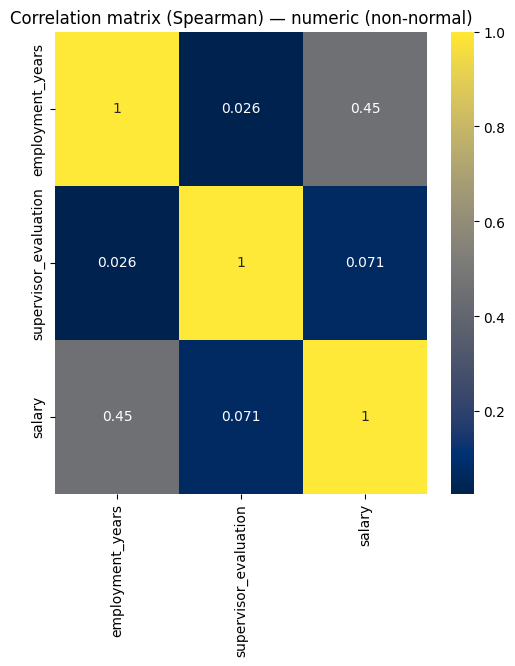

In [66]:
num_cols_test_quit = test_quit_merged.select_dtypes(include='number').columns.tolist()
num_cols_test_quit = [c for c in num_cols_test_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(test_quit_merged[num_cols_test_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [67]:
test_quit_merged[num_cols_test_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary
employment_years,1.000000,0.026278,0.452343
supervisor_evaluation,0.026278,1.000000,0.071399
salary,0.452343,0.071399,1.000000


#### Выводы по корреляционному анализу (test)

- Существенных расхождений между train и test по структуре зависимостей не обнаружено.

- Использование тестовой выборки для оценки качества модели корректно: паттерны связей и относительные силы предикторов совпадают с обучающей выборкой.

- Следовательно, сравнивать и интерпретировать показатели качества (ROC-AUC, SMAPE) на test можно без риска систематического смещения из-за различий в данных.

### Портрет «уволившегося сотрудника» <a id="сотрудник"></a>

#### Связь признаков с quit

__1. Связь employment_years__

In [68]:
train_quit.groupby('quit')['employment_years'].mean()

quit
no     4.430710
yes    1.844858
Name: employment_years, dtype: float64

In [69]:
phik_corr_quit.loc['quit', 'employment_years']

np.float64(0.6590927481335395)

Средний стаж:

- У оставшихся: 4.43 года

- У уволившихся: 1.84 года

__Вывод:__ Увольняются преимущественно молодые сотрудники со стажем до 2 лет.
Хотя корреляция Phik (0.66) высокая, направление связи обратное: чем меньше стаж — тем выше вероятность увольнения.

In [70]:
# распределение employment_years среди ушедших/оставшихся (в %)
emp_by_quit_pct = (
    train_quit
      .pivot_table(index='employment_years', columns='quit', values='id', aggfunc='count')
      .apply(lambda col: col / col.sum() * 100)
      .fillna(0)
)

emp_by_quit_pct

quit,no,yes
employment_years,,
1,13.440111,53.102837
2,16.956825,25.709220
3,11.002786,14.450355
4,12.743733,2.393617
5,11.803621,2.039007
6,9.958217,0.886525
7,10.480501,0.620567
8,5.954039,0.265957
9,4.630919,0.265957


__Вывод:__

- Доля сотрудников со стажем 1–2 года среди уволившихся существенно выше (53% и 26%), чем среди оставшихся (13% и 17%).
- Начиная с 3 лет стажа, доли уволившихся резко снижаются — при стаже более 5 лет увольнение становится редким случаем (менее 3%).
- Таким образом, наибольший риск увольнения наблюдается у сотрудников с коротким стажем (до 2 лет), что подтверждает ранее выявленную обратную зависимость между стажем и вероятностью ухода.

__2. Связь salary__

In [71]:
# средняя зарплата по группам
train_quit.groupby('quit')['salary'].mean()

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64

In [72]:
train_quit['salary'].mean()

np.float64(33805.8)

In [73]:
phik_corr_quit.loc['quit', 'salary']

np.float64(0.564153891893097)

__Вывод:__ уволившиеся получают ниже среднего.
Разрыв почти 14 000 у.е. указывает, что низкооплачиваемые сотрудники чаще покидают компанию.

__3. Связь level__

In [74]:
# распределение уровней среди ушедших/оставшихся (в %)
(train_quit
 .pivot_table(index='level', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
level,,
junior,32.938719,88.918440
middle,55.222841,9.574468
senior,11.838440,1.507092


In [75]:
phik_corr_quit.loc['quit', 'level']

np.float64(0.31279880507754565)

Phik = 0.31 — средняя связь.

__Вывод:__ почти 9 из 10 уволившихся — junior-специалисты.
Чем выше уровень должности, тем реже увольнение.

__4. Связь Загруженность (workload)__

In [76]:
# распределение workload среди ушедших/оставшихся (в %)
(train_quit
 .pivot_table(index='workload', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
workload,,
high,19.254875,10.726950
low,23.990251,46.010638
medium,56.754875,43.262411


In [77]:
phik_corr_quit.loc['quit', 'workload']

np.float64(0.13224343729049595)

Phik = 0.13 — слабая связь.

__Вывод:__ низкая и средняя загруженность преобладает у уволившихся.
Возможно, сотрудники с низкой нагрузкой менее вовлечены или недооценены.

__5. Связь Оценка руководителя (supervisor_evaluation)__

In [78]:
# распределение supervisor_evaluation среди ушедших/оставшихся (в %)
(train_quit
 .pivot_table(index='supervisor_evaluation', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
supervisor_evaluation,,
1,3.725627,8.421986
2,7.903900,14.539007
3,24.721448,46.365248
4,47.632312,25.354610
5,16.016713,5.319149


In [79]:
phik_corr_quit.loc['quit', 'supervisor_evaluation']

np.float64(0.24548907299383685)

Phik = 0.25 — умеренная связь.

__Вывод:__ уволившиеся чаще имеют оценку 3 от руководителя,
тогда как среди оставшихся доминирует оценка 4.

__6. Связь Нарушения (last_year_violations)__

In [80]:
# распределение last_year_violations среди ушедших/оставшихся (в %)
(train_quit
 .pivot_table(index='last_year_violations', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
last_year_violations,,
no,88.962396,79.787234
yes,11.037604,20.212766


In [81]:
phik_corr_quit.loc['quit', 'last_year_violations']

np.float64(0.18507136256390683)

Phik = 0.19 — слабая, но заметная связь.

__Вывод:__ дисциплинарные нарушения не является предиктором увольнения, тем не менее доля сотрудников с дисциплинарными нарушениями в два раза выше среди уволившихся.

__7. Связь Повышения (last_year_promo)__

In [82]:
# распределение last_year_promo среди ушедших/оставшихся (в %)
(train_quit
 .pivot_table(index='last_year_promo', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
last_year_promo,,
no,96.100279,99.911348
yes,3.899721,0.088652


In [83]:
phik_corr_quit.loc['quit', 'last_year_promo']

np.float64(0.1573700971549875)

Phik = 0.16 — слабая связь.

__Вывод:__ почти никто из уволившихся не получал повышение в прошлом году.
Отсутствие карьерного роста — один из возможных факторов ухода.

__8. Связь Отдела (dept)__

In [84]:
# распределение уровней среди ушедших/оставшихся (в %)
(train_quit
 .pivot_table(index='dept', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
dept,,
hr,12.116992,10.283688
marketing,14.589136,14.450355
purchasing,14.693593,14.716312
sales,35.898329,36.081560
technology,22.701950,24.468085


In [85]:
phik_corr_quit.loc['quit', 'dept']

np.float64(0.0)

Phik = 0.00 — связи нет.

__Вывод:__ вероятность увольнения не зависит от отдела.
Структура по департаментам практически одинакова у обеих групп.



#### Вывод

**Основные зависимости**

1. **Стаж работы (employment_years)**

   Уходят преимущественно молодые сотрудники, не проработавшие в компании и двух лет.
   

2. **Зарплата (salary)**

   Увольняются в основном **низкооплачиваемые сотрудники**, получающие меньше среднего уровня оплаты.
   

3. **Уровень должности (level)**

    Вероятность увольнения резко уменьшается с ростом профессионального уровня; почти все увольняющиеся — **начинающие специалисты**.


4. **Загруженность (workload)**

    **Низкая или средняя загруженность** чаще встречается среди ушедших, что может отражать недостаток вовлечённости или мотивации.


5. **Оценка руководителя (supervisor_evaluation)**

   Увольняющиеся в целом получают **ниже оценки от руководителей**, что может свидетельствовать о проблемах в эффективности или коммуникации.


6. **Нарушения дисциплины (last_year_violations)**

   Несмотря на то, что нарушения не являются прямым предиктором увольнения, их доля среди ушедших **в два раза выше**, что подтверждает связь с низкой дисциплиной и вовлечённостью.


7. **Повышения (last_year_promo)**

   **Отсутствие карьерного роста** является демотивирующим фактором, повышающим риск увольнения.


8. **Отдел (dept)**

   Увольнение **не зависит от департамента** — текучесть носит горизонтальный, а не функциональный характер.


#### Итоговый портрет уволившегося сотрудника

__Типичный уволившийся сотрудник__ — 
- начинающий junior-специалист 
- со стажем менее 2 лет,
- низкой заработной платой (~24 тыс. у.е.),
- оценкой руководителя 3 или ниже,
- без повышения в прошлом году,
- иногда с нарушениями дисциплины,
- при этом его загруженность низкая или средняя,
- а принадлежность к отделу значения не имеет.

__Практические выводы для управления персоналом__

- Основная зона риска — новички и младшие специалисты.

- Материальная мотивация, карьерное развитие и позитивная оценка руководителя — ключевые факторы удержания.

Рекомендуется усилить:

- адаптационные и менторские программы в первые 1–2 года работы;

- систему поощрений и внутренних повышений;

- обратную связь и вовлечённость сотрудников с низкой загрузкой.

### Проверка утверждения: «Уровень удовлетворённости сотрудника работой (job_satisfaction_rate) влияет на то, уволится ли сотрудник.» <a id="проверка"></a>

У нас есть:

- тестовая выборка признаков test_features (в ней — id, dept, salary, supervisor_evaluation и др.);

- целевая переменная job_satisfaction_rate (уровень удовлетворённости) из файла test_target;

- целевая переменная quit (уволился / остался) из файла test_target_quit.

#### Объединим данные

In [86]:
df = test_features.merge(test_target, on='id').merge(test_target_quit, on='id')

In [87]:
df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


#### Визуализация распределений (как распределён уровень удовлетворённости у тех, кто остался, и у тех, кто уволился.)

__Boxplot (ящик с усами)__

C:\Users\nursu\AppData\Local\Temp\ipykernel_22328\431442276.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quit', y='job_satisfaction_rate', data=df, palette='Set2')


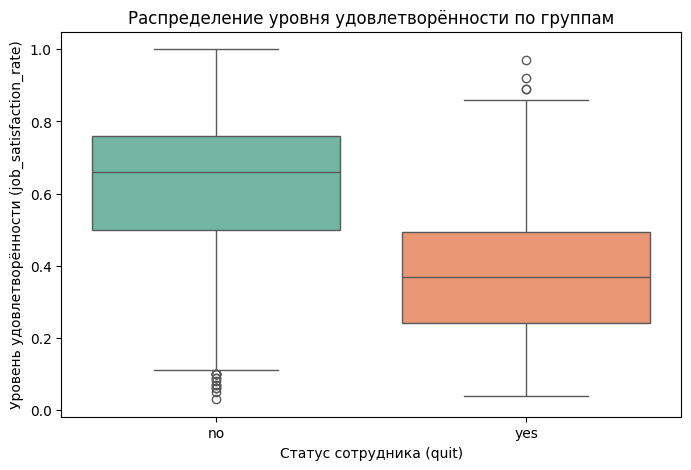

In [88]:
plt.figure(figsize=(8,5))
sns.boxplot(x='quit', y='job_satisfaction_rate', data=df, palette='Set2')
plt.title('Распределение уровня удовлетворённости по группам')
plt.xlabel('Статус сотрудника (quit)')
plt.ylabel('Уровень удовлетворённости (job_satisfaction_rate)')
plt.show()

__Гистограммы__

C:\Users\nursu\AppData\Local\Temp\ipykernel_22328\1846224893.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['quit']=='no']['job_satisfaction_rate'], label='Остались', shade=True)
C:\Users\nursu\AppData\Local\Temp\ipykernel_22328\1846224893.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['quit']=='yes']['job_satisfaction_rate'], label='Уволились', shade=True)


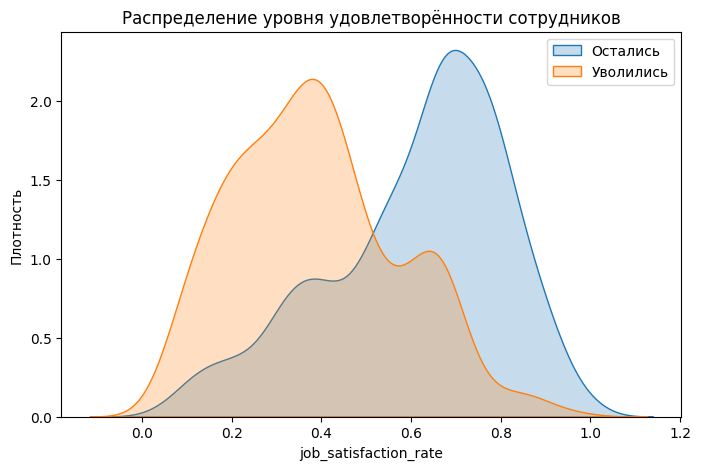

In [89]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df['quit']=='no']['job_satisfaction_rate'], label='Остались', shade=True)
sns.kdeplot(df[df['quit']=='yes']['job_satisfaction_rate'], label='Уволились', shade=True)
plt.title('Распределение уровня удовлетворённости сотрудников')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Плотность')
plt.legend()
plt.show()


__На boxplot и графике плотностей (KDE)__ отчётливо видно, что распределения уровня удовлетворённости для двух групп существенно различаются:

- У оставшихся сотрудников медианное значение удовлетворённости составляет около 0.66,
- 75% значений находятся выше 0.5, а максимумы достигают 1.0.

- У уволившихся сотрудников медианное значение около 0.37,
- большая часть распределения сосредоточена в диапазоне 0.2–0.5.

__Статистическое сравнение__

In [90]:
df.groupby('quit')['job_satisfaction_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1436.0,0.612040,0.199367,0.03,0.50,0.66,0.7600,1.00
yes,564.0,0.387713,0.185784,0.04,0.24,0.37,0.4925,0.97


Разница в средних значениях составляет примерно 0.22 пункта, что является существенным при шкале от 0 до 1.

#### Вывод

- Уровень удовлетворённости работой оказывает значительное влияние на вероятность увольнения.

- Сотрудники с низкими значениями job_satisfaction_rate (до 0.4) гораздо чаще покидают компанию,
тогда как у тех, кто остаётся, уровень удовлетворённости стабильно выше среднего (0.6–0.8).

- Наблюдается отчётливая отрицательная зависимость: чем ниже удовлетворённость, тем выше риск увольнения.

- Полученные результаты подтверждают гипотезу аналитиков о влиянии удовлетворённости на текучесть кадров.


#### Статистическая проверка гипотезы

__Цель:__ проверить, действительно ли различие уровней удовлетворённости (job_satisfaction_rate) между группами уволившихся и оставшихся статистически значимо.


__1. Формулировка гипотез__

* **Нулевая гипотеза (H₀):** средние значения job_satisfaction_rate у уволившихся и оставшихся не различаются.
  То есть уровень удовлетворённости не влияет на вероятность увольнения.

* **Альтернативная гипотеза (H₁):** средние значения job_satisfaction_rate различаются между группами.
  То есть уровень удовлетворённости влияет на вероятность увольнения.

__2. Проведение теста__

In [91]:
# Разделяем группы
stay = df[df['quit'] == 'no']['job_satisfaction_rate']
leave = df[df['quit'] == 'yes']['job_satisfaction_rate']

# t-тест для независимых выборок (разные дисперсии)
t_stat, p_value = ttest_ind(stay, leave, equal_var=False)

print(f"T-статистика: {t_stat:.3f}")
print(f"P-значение: {p_value:.6f}")

T-статистика: 23.795
P-значение: 0.000000


__Результаты:__

T-статистика: 23.795  
P-значение: 0.000000


__3 Интерпретация__

Так как **p-value < 0.05**, нулевая гипотеза отвергается.
Различия между средними уровнями удовлетворённости в группах статистически значимы.
Высокое значение t-статистики (23.795) показывает, что разница между средними выражена значительно сильнее, чем внутренняя вариация в группах.
Таким образом, наблюдаемая разница не случайна и отражает реальное влияние уровня удовлетворённости на текучесть кадров.


**Вывод**

Результаты t-теста подтверждают, что уровень удовлетворённости сотрудника работой является значимым фактором увольнения.
Средний уровень удовлетворённости у оставшихся выше, и эта разница статистически достоверна.

Таким образом, гипотеза о влиянии удовлетворённости на увольнение подтверждается с высокой степенью уверенности:
чем ниже job_satisfaction_rate, тем выше вероятность ухода сотрудника из компании.


### Добавление нового входного признака<a id="добавление"></a>

Необходимо добавить ещё один новый признак — job_satisfaction_rate_pred, который является уровнем удовлетворённости предсказанным моделью первой задачи.

__Предсказываем job_satisfaction_rate и добавляем столбец в train_quit и test_features__

In [92]:
# список признаков, на которых обучалась модель
features = ['dept', 'level', 'workload', 'employment_years',
            'last_year_promo', 'last_year_violations',
            'supervisor_evaluation', 'salary']

train_quit['job_satisfaction_pred'] = best_model.predict(train_quit[features])
test_features['job_satisfaction_pred'] = best_model.predict(test_features[features])

__Проверка__

In [93]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.605000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


In [94]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.643333
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500


#### Correlation matrix (Phik: числовые + категориальные)

__Для тренировочной выборки__

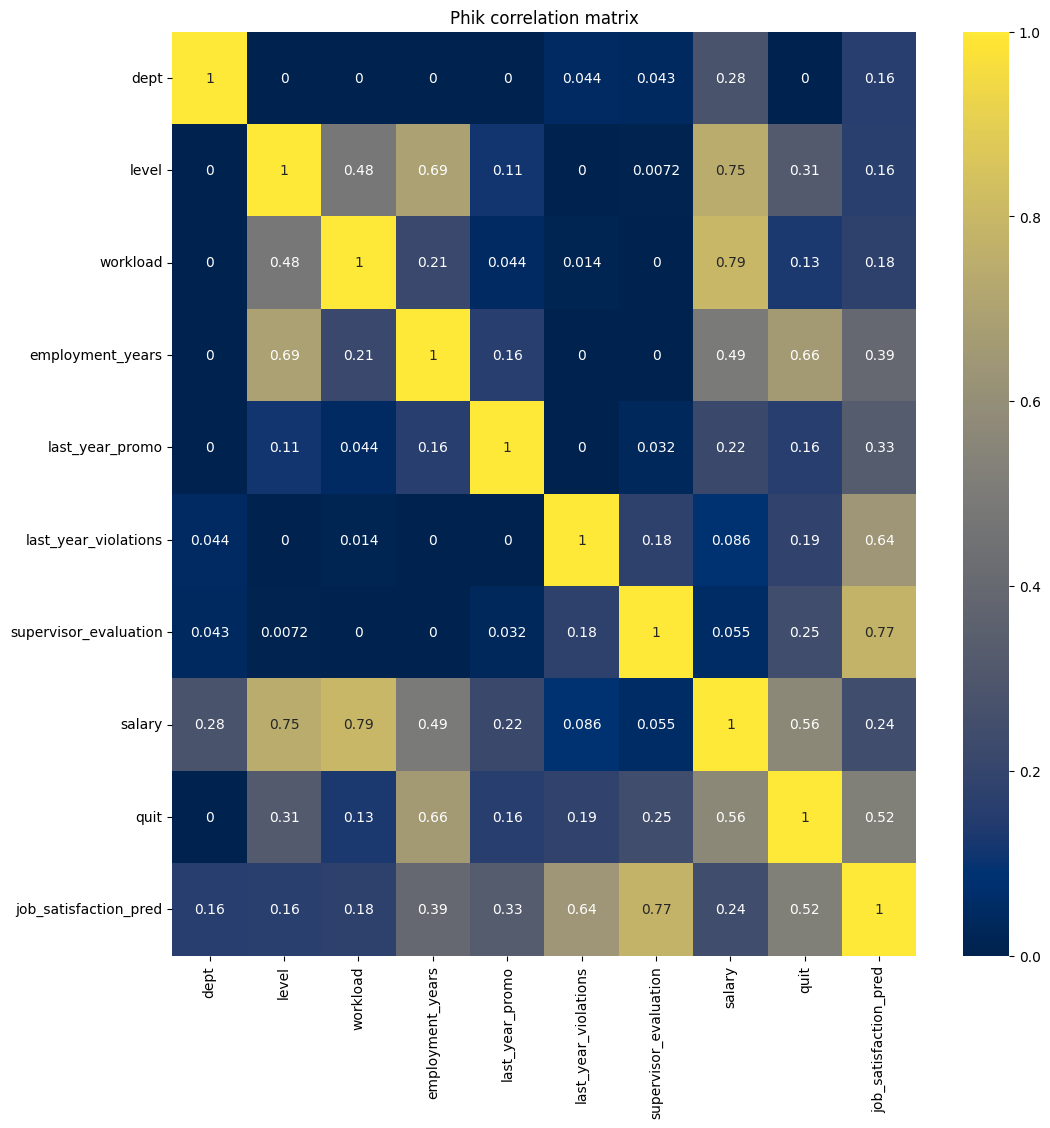

In [95]:
interval_cols_quit = [c for c in continuous if c in train_quit.columns]

phik_corr_quit = train_quit.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [96]:
phik_corr_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_pred
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000,0.156542
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799,0.162732
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243,0.176397
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093,0.391530
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370,0.325295
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071,0.637450
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489,0.773681
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154,0.244994
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000,0.518780
job_satisfaction_pred,0.156542,0.162732,0.176397,0.391530,0.325295,0.637450,0.773681,0.244994,0.518780,1.000000


__Для тестовой выборки__

In [97]:
# объединяем test_features (признаковые колонки) и test_target_quit (целевую колонку)
test_quit_merged = test_features.merge(test_target_quit, on='id')

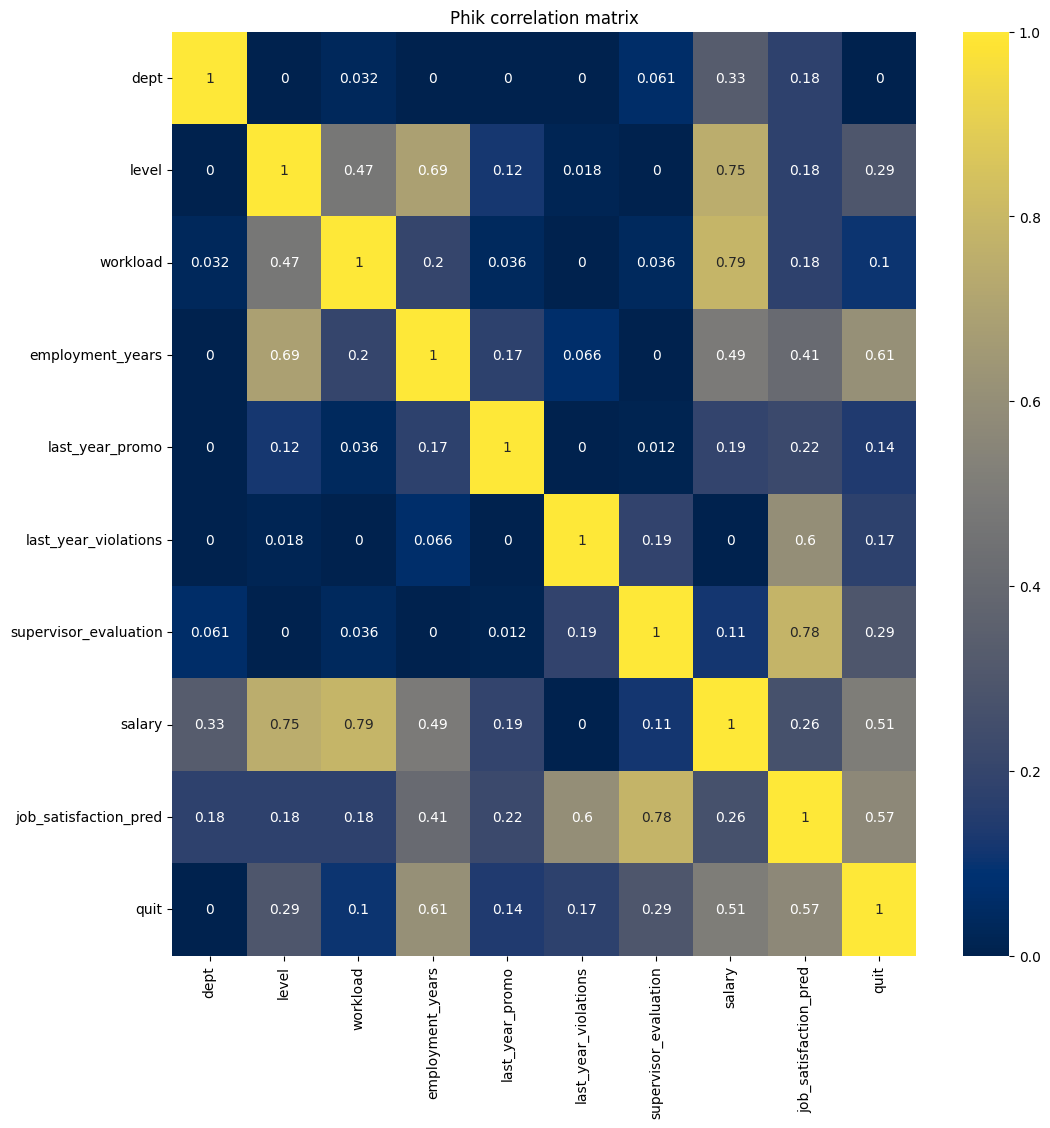

In [98]:
# phik
interval_cols_test_quit = [c for c in continuous if c in test_quit_merged.columns]

phik_corr_test_quit = test_quit_merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_test_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_test_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [99]:
phik_corr_test_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_pred,quit
dept,1.000000,0.000000,0.032212,0.000000,0.000000,0.000000,0.061389,0.330327,0.178692,0.000000
level,0.000000,1.000000,0.474370,0.689666,0.118258,0.017527,0.000000,0.748998,0.176253,0.293623
workload,0.032212,0.474370,1.000000,0.202096,0.035565,0.000000,0.035920,0.785872,0.179117,0.102236
employment_years,0.000000,0.689666,0.202096,1.000000,0.173637,0.066371,0.000000,0.494701,0.406888,0.605927
last_year_promo,0.000000,0.118258,0.035565,0.173637,1.000000,0.000000,0.011704,0.193727,0.219215,0.137762
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.600976,0.174740
supervisor_evaluation,0.061389,0.000000,0.035920,0.000000,0.011704,0.189719,1.000000,0.114588,0.782190,0.294738
salary,0.330327,0.748998,0.785872,0.494701,0.193727,0.000000,0.114588,1.000000,0.262841,0.508308
job_satisfaction_pred,0.178692,0.176253,0.179117,0.406888,0.219215,0.600976,0.782190,0.262841,1.000000,0.568785
quit,0.000000,0.293623,0.102236,0.605927,0.137762,0.174740,0.294738,0.508308,0.568785,1.000000


#### Correlation matrix (Spearman)

__Для тренировочной выборки__

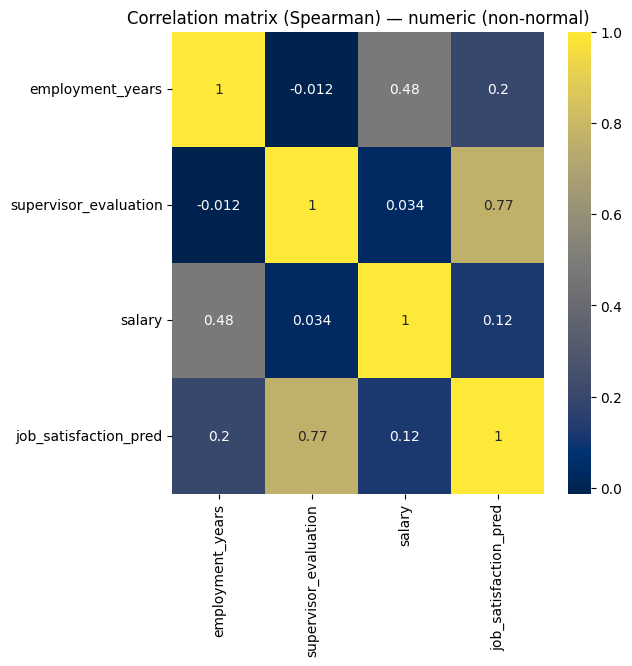

In [100]:
num_cols_quit = train_quit.select_dtypes(include='number').columns.tolist()
num_cols_quit = [c for c in num_cols_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(train_quit[num_cols_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [101]:
train_quit[num_cols_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_pred
employment_years,1.000000,-0.012320,0.478214,0.200210
supervisor_evaluation,-0.012320,1.000000,0.033737,0.765234
salary,0.478214,0.033737,1.000000,0.122123
job_satisfaction_pred,0.200210,0.765234,0.122123,1.000000


__Для тестовой выборки__

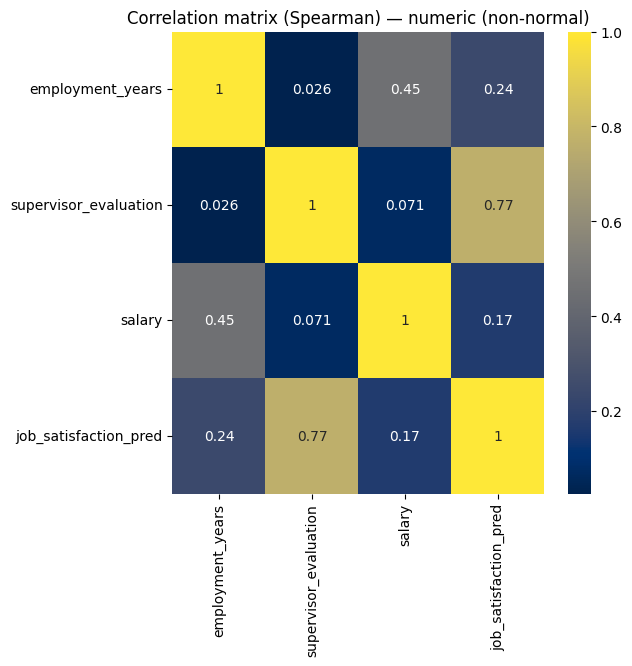

In [102]:
num_cols_test_quit = test_quit_merged.select_dtypes(include='number').columns.tolist()
num_cols_test_quit = [c for c in num_cols_test_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(test_quit_merged[num_cols_test_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [103]:
test_quit_merged[num_cols_test_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_pred
employment_years,1.000000,0.026278,0.452343,0.239453
supervisor_evaluation,0.026278,1.000000,0.071399,0.766747
salary,0.452343,0.071399,1.000000,0.165910
job_satisfaction_pred,0.239453,0.766747,0.165910,1.000000


#### Выводы по корреляционному анализу

__Phik (числовые + категориальные)__

__Train (train_quit):__

- Связь с таргетом quit:
  job_satisfaction_pred ↔ quit = 0.519 — связь средней силы, признак информативен, но не доминирует.
- Наибольшие связи job_satisfaction_pred наблюдаются с:
  supervisor_evaluation (0.774), last_year_violations (0.637).
- Явной сильной связи среди признаков не наблюдается

__Test (test_quit_merged):__

* job_satisfaction_pred ↔ quit = 0.569 — немного выше, чем на train, но в том же диапазоне (средняя сила).
* Профиль связей c другими факторами сохраняется: сильнее всего с supervisor_evaluation (0.782), затем last_year_violations (0.601).
- Явной сильной связи среди признаков не наблюдается

**Вывод по Phik:** структура зависимостей **стабильна между train и test**


__Spearman (только числовые)__

**Train:**

* job_satisfaction_pred имеет высокую связь с supervisor_evaluation (ρ≈0.765)
* Явной линейной мультиколлинеарности среди числовых не наблюдается

**Test:**

* Картина близка к train:
  job_satisfaction_pred ↔ supervisor_evaluation (ρ≈0.767) — высокая

**Вывод по Spearman:** линейная взаимозависимость числовых предикторов умеренная, критичных пар со сверхвысокими корреляциями нет.

### Подготовка данных<a id="подготовка"></a>

Подготовка данных

- Используется единый ColumnTransformer

- OneHotEncoder для номинальных признаков (dept) с drop='first';

- OrdinalEncoder для упорядоченных категорий (level, workload, last_year_promo, last_year_violations) с заданным порядком классов; предварительная и последующая импутация модой — для устойчивости к пропускам/невиданным категориям;

- Числовые (employment_years, supervisor_evaluation, salary, job_satisfaction_pred) — медианная импутация и масштабирование (StandardScaler/MinMaxScaler/passthrough, подбирается в CV).

__Удаляем id, считаем дубликаты__

In [104]:
train_quit.drop(columns=['id']).duplicated().sum()

np.int64(1413)

__Удаляем дубликаты__

In [105]:
train_2_no_id = train_quit.drop(columns=['id']).drop_duplicates(keep='first')
print(f"Размер до: {train_quit.drop(columns=['id']).shape}, после: {train_2_no_id.shape}")

Размер до: (4000, 10), после: (2587, 10)


In [106]:
X_train_2 = train_2_no_id.drop(columns=['quit'])
y_train_2 = train_2_no_id['quit']

__Результат:__

Обнаружено и удалено 1413 полных дубликатов.

Размер обучающей выборки уменьшился с 4000 → 2587 строк, что повысило чистоту данных.

Разделение на X_train_2 и y_train_2 выполнено после дедупликации, поэтому индексы синхронизированы.

Проверка проводилась только для train, так как в тестовой выборке данные не изменяются (имитирует реальный поток).

In [107]:
X_test_2 = test_features.set_index('id').sort_index()
y_test_2 = (test_target_quit
          .set_index('id')
          .sort_index()['quit']) 

label_encoder = LabelEncoder()
y_train_2_label = label_encoder.fit_transform(y_train_2)
y_test_2_label = label_encoder.transform(y_test_2)

In [108]:
print("Размерности выборок:")
print("X_train_2:", X_train_2.shape)
print("X_test_2:", X_test_2.shape)
print("y_train_2_label:", y_train_2_label.shape)
print("y_test_2_label:", y_test_2_label.shape)

# списки признаков
# OHE: номинальная категория без порядка
ohe_columns_2 = ['dept']

# Ordinal: упорядоченные категории
ord_columns_2 = ['level', 'workload', 'last_year_promo', 'last_year_violations']

# Числовые фичи без таргета и id
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_pred']

# --- пайплайны кодирования/импутации ---
ohe_pipe_2 = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# порядок категорий
ord_categories_2 = [
    ['junior', 'middle', 'senior'],   # level
    ['low', 'medium', 'high'],        # workload
    ['no', 'yes'],                    # last_year_promo
    ['no', 'yes']                     # last_year_violations
]

ord_pipe_2 = Pipeline(steps=[
    ('impute_before', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=ord_categories,
                           handle_unknown='use_encoded_value',
                           unknown_value=np.nan)),
    ('impute_after', SimpleImputer(strategy='most_frequent'))
])

num_pipe_2 = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# --- общий препроцессор ---
data_preprocessor_2 = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns),
    ],
    remainder='drop'
)

Размерности выборок:
X_train_2: (2587, 9)
X_test_2: (2000, 9)
y_train_2_label: (2587,)
y_test_2_label: (2000,)


__Кодирование выполнен с помощью трансформера LabelEncoder.__
__Проверка присвоенных меток:__

In [109]:
pd.DataFrame(y_train_2_label, y_train_2, columns=['LabelEncoder']).head()

,LabelEncoder
quit,
no,0
no,0
no,0
yes,1
no,0


### Обучение модели (Задача 2: предсказать quit) <a id="обучение"></a>

__Метрика:__ ROC-AUC 

__Цель:__ бинарная классификация (quit: yes/no).

__Признаки:__ фичи из задачи 1 + job_satisfaction_pred (предсказание из Задачи 1).


#### Decision Tree Classifier

- Общий пайплайн: preprocessor + DecisionTreeClassifier.
- Подбираем через RandomizedSearchCV(cv=5, scoring='roc_auc', n_iter=35):

    - max_depth, min_samples_split, min_samples_leaf,

    - тип масштабирования числовых через preprocessor__num__scale (для дерева не критично, но допустимо).

In [110]:
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_distributions_1 = {
    'model__max_depth': range(2, 20),
    'model__min_samples_split': range(2, 10),
    'model__min_samples_leaf': range(2, 10),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']  
}

randomized_search_1 = RandomizedSearchCV(
    pipe_final_1, 
    param_distributions_1, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=35,
    n_jobs=-1
)

randomized_search_1.fit(X_train_2, y_train_2_label)

print("Лучшие параметры:", randomized_search_1.best_params_)
print("Лучший roc_auc:", randomized_search_1.best_score_)

Лучшие параметры: {'preprocessor__num__scale': StandardScaler(), 'model__min_samples_split': 4, 'model__min_samples_leaf': 6, 'model__max_depth': 5}
Лучший roc_auc: 0.9030844586055874


__Лучшие параметры:__
{'preprocessor__num__scale': StandardScaler(), 'model__min_samples_split': 4, 'model__min_samples_leaf': 6, 'model__max_depth': 5}

Лучший ROC-AUC (CV): 0.903


__Вывод:__
Дерево с умеренной глубиной и ограничениями по листьям показало высокое качество (ROC-AUC ≈ 0.903).
Масштабирование необязательно для деревьев, но в комбинации с категориальными кодировками могло немного улучшить устойчивость разбиений.

#### K-Nearest Neighbors (KNN) Classifier

- Общий пайплайн: preprocessor + KNeighborsClassifier.

- Подбираем: n_neighbors, тип скейлера через preprocessor__num__scale.

- KNN обязательно требует масштабирования.

In [111]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', KNeighborsClassifier())
])

param_distributions_2 = {
    'model__n_neighbors': range(2, 15),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler()] 
}

randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_distributions_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=25,
    n_jobs=-1
)

randomized_search_2.fit(X_train_2, y_train_2_label)

print("Лучшие параметры:", randomized_search_2.best_params_)
print("Лучший roc_auc:", randomized_search_2.best_score_)

Лучшие параметры: {'preprocessor__num__scale': StandardScaler(), 'model__n_neighbors': 14}
Лучший roc_auc: 0.8978644892274236


__Лучшие параметры:__
{'preprocessor__num__scale': StandardScaler(), 'model__n_neighbors': 14}

Лучший ROC-AUC (CV): 0.897

__Вывод:__
Модель KNN показала стабильное качество (ROC-AUC ≈ 0.897).
Использование StandardScaler оказалось оптимальным — оно снизило искажения между фичами и улучшило результат.

#### Logistic Regression 

- Общий пайплайн: preprocessor + LogisticRegression c L1.
- Подбираем: C и тип скейлера.
- Для L1 используем solver='liblinear', целевая — 0/1

In [112]:
pipe_final_3 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'))])

param_distributions_3 = {
    'model__C': range(1, 15),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']  
}

randomized_search_3 = RandomizedSearchCV(
    pipe_final_3, 
    param_distributions_3, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=20,
    n_jobs=-1
)

randomized_search_3.fit(X_train_2, y_train_2_label)

print("Лучшие параметры:", randomized_search_3.best_params_)
print("Лучший roc_auc:", randomized_search_3.best_score_)

Лучшие параметры: {'preprocessor__num__scale': 'passthrough', 'model__C': 9}
Лучший roc_auc: 0.9010193805092758


__Лучшие параметры:__
{'preprocessor__num__scale': 'passthrough', 'model__C': 9}

Лучший ROC-AUC (CV): 0.901

__Вывод:__
Логистическая регрессия показала сопоставимое с деревом качество (ROC-AUC ≈ 0.90), но уступила по гибкости.
L1-регуляризация помогла исключить малозначимые признаки и снизить переобучение, сохранив интерпретируемость модели.

#### Проверка на тестовой выборке и вывод

После сравнительного анализа на кросс-валидации для финальной проверки на тестовой выборке выбрана Decision Tree Classifier — лучшая модель по метрике ROC-AUC.

In [113]:
best_model_2 = randomized_search_1.best_estimator_
y_pred_proba = best_model_2.predict_proba(X_test_2)[:, 1]
test_auc = roc_auc_score(y_test_2_label, y_pred_proba)
print(f"ROC-AUC на тестовой выборке: {test_auc:.3f}")

ROC-AUC на тестовой выборке: 0.912


__Результаты:__

CV ROC-AUC: 0.903

Test ROC-AUC: 0.912

__Итоговый вывод:__

Лидером по ROC-AUC стала модель Decision Tree Classifier (CV ≈ 0.903, Test ≈ 0.912).

KNN и Logistic Regression показали сопоставимые результаты (ROC-AUC ≈ 0.897 и 0.901 соответственно), однако дерево решений обладает рядом преимуществ.

__Почему дерево лучше в этой задаче__

- Нелинейность: дерево улавливает пороговые эффекты и взаимодействия категорий с числовыми

- Робастность: слабая чувствительность к масштабам и выбросам

- Контроль сложности: оптимальные max_depth, min_samples_split/leaf ограничивают переобучение.

__Заключение:__

Модель Decision Tree Classifier успешно прошел тест по критерию успеха ROC-AUC и может быть рекомендована как основная модель для предсказания вероятности увольнения сотрудников (quit).

In [114]:
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train_2, y_train_2_label)

dummy_pred = dummy.predict_proba(X_test_2)[:, 1]
dummy_auc = roc_auc_score(y_test_2_label, dummy_pred)

best_auc = roc_auc_score(y_test_2_label, randomized_search_1.predict_proba(X_test_2)[:, 1])

print(f'ROC-AUC DummyClassifier: {dummy_auc:.3f}')
print(f'ROC-AUC DecisionTreeClassifier: {best_auc:.3f}')
print(f'Превышение над бейзлайном: {best_auc - dummy_auc:.3f}')


ROC-AUC DummyClassifier: 0.500
ROC-AUC DecisionTreeClassifier: 0.912
Превышение над бейзлайном: 0.412


__Результат:__

Модель Decision Tree Classifier показала ROC-AUC значительно выше, чем DummyClassifier, что подтверждает её адекватность и реальную предсказательную способность.
Таким образом, итоговая модель действительно извлекает закономерности из данных, а не повторяет константное предсказание.

## Общий вывод по проекту<a id="выводы"></a>

**Общий вывод**

В ходе проекта была решена ключевая бизнес-задача HR-аналитики — **прогнозирование уровня удовлетворённости сотрудников и вероятности их увольнения** на основе внутренних данных компании.
Результаты позволили не только определить основные факторы, влияющие на мотивацию и вовлечённость персонала, но и сформировать **практические рекомендации для снижения текучести кадров** и повышения удержания сотрудников.


**Этапы работы**

1. **Предобработка и исследование данных.**
   Проведён детальный анализ набора данных, включающего параметры сотрудников: отдел, уровень, стаж, нагрузку, дисциплинарные нарушения, факты повышения, зарплату и оценку руководителя.
   Были выявлены пропуски и устранены логическим восстановлением на основе близких по характеристикам наблюдений.

2. **Подготовка данных.**
   Выполнены следующие шаги:

   * импутация пропущенных значений;
   * кодирование категориальных признаков (One-Hot, OrdinalEncoder);
   * масштабирование числовых переменных (StandardScaler, MinMaxScaler);
   * удаление неинформативных признаков (`id`).

3. **Построение и обучение моделей.**
   Для решения задач использованы различные алгоритмы машинного обучения:

   * **Decision Tree Regressor** — для прогнозирования уровня удовлетворённости;
   * **Ridge Regression** — для оценки влияния линейных факторов с L2-регуляризацией;
   * **Decision Tree Classifier**, **K-Nearest Neighbors (KNN)** и **Logistic Regression (L1)** — для прогнозирования увольнения.
     Подбор гиперпараметров выполнялся с помощью `RandomizedSearchCV` (cv=5, scoring по SMAPE и ROC-AUC).

4. **Оценка и сравнение моделей.**

   * В задаче прогнозирования удовлетворённости наилучшее качество показал **DecisionTreeRegressor** (Test SMAPE ≈ 13.35%).
   * В задаче прогнозирования увольнений лидером стала **DecisionTreeClassifier** с **0.912 на тестовой выборке**.
     Это подтвердило эффективность деревьев решений в анализе данных со смешанными типами признаков и нелинейными взаимосвязями.


**Выводы**

* Ключевыми драйверами удовлетворённости сотрудников оказались **оценка руководителя** и **отсутствие дисциплинарных нарушений**.
* **Зарплата, стаж и уровень должности** взаимосвязаны и влияют на вероятность увольнения опосредованно.
* Основная зона риска — **новички и младшие специалисты** с низкой или средней загруженностью и невысокой оценкой руководителя.
* Модели подтвердили, что сочетание объективных факторов (зарплата, стаж) и субъективных (оценка, вовлечённость) даёт наиболее точное предсказание поведения сотрудников.


**Рекомендации для бизнеса**

1. Развивать программы адаптации и наставничества для сотрудников со стажем до 2 лет.
2. Усилить систему поощрений и карьерного роста, так как отсутствие повышения напрямую связано с повышенным риском увольнений.
3. Повысить вовлечённость руководителей в управление командой — именно их оценка является основным предиктором удовлетворённости.
4. Внедрить систему предиктивной HR-аналитики, отслеживающую динамику удовлетворённости и автоматически выявляющую группы риска увольнения.
5. Использовать полученные модели как основу для «умной системы управления персоналом», интегрирующей прогнозирование, визуализацию и рекомендации.


 **Итог**

Проект показал, что использование методов машинного обучения позволяет автоматизировать анализ HR-данных, повысить точность прогнозов и перейти от реактивного управления персоналом к проактивной стратегии удержания сотрудников.
Реализация подобных моделей может стать шагом к созданию интеллектуальной системы управления человеческим капиталом, которая объединяет прогноз удовлетворённости, оценку риска увольнения и рекомендации по повышению мотивации и эффективности сотрудников.